<a href="https://colab.research.google.com/github/RAnanya/ALS-patient-risk-models/blob/main/ALS_model_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
#One-time authentication

In [ ]:
!pip install -U -q PyDrive
!pip install gower
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
#instals pydrive: to be able to read directly from Google drive

import numpy as np
import pandas as pd
import requests
import warnings
from io import StringIO
import os
warnings.filterwarnings("ignore")
from scipy import stats
# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import sys

import matplotlib.pyplot as plt
#from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import DistanceMetric
import gower
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram

%matplotlib inline

In [ ]:
dtypes = {'pid' :'category',
 'f_male_bl':'category',
 'race_bl':'category',
 'ethnic_bl':'category',
 'f_onset_bulbar_bl':'category',
 'f_onset_limb_bl':'category',
 'f_onset_spine_bl':'category',
 'f_riluzole_bl':'category',
 'f_study_drug_bl':'category',
 'visit':'category'}

In [ ]:
#Import the pre-processed data; after the cleaning and missing/outlier treatment
#Import FVC dataset
baseline = pd.read_csv('/content/drive/MyDrive/Synopsys_ScienceFair/Data/baseline_demo_all_new.csv', index_col=0, dtype=dtypes)
fvc = pd.read_csv('/content/drive/MyDrive/Synopsys_ScienceFair/Data/Fvc.csv', index_col=0, dtype=dtypes)

In [ ]:
#Some more missing value treatment; drop RBC data given the poor quality

baseline['Onset_Delta'].fillna(0, inplace=True)
baseline['Diagnosis_Delta'].fillna(0, inplace=True)
baseline.drop(columns = ['RBC_median','RBC_slope','RBC_min'], axis=1, inplace=True)

In [ ]:
#Treatment and Transformation of FVC data

fvc["Pct_Normal"] =fvc[['pct_of_Normal_Trial_1','pct_of_Normal_Trial_2','pct_of_Normal_Trial_3']].max(axis=1)
fvc["Liters_Trial"] =fvc[['Subject_Liters_Trial_1','Subject_Liters_Trial_2','Subject_Liters_Trial_3']].max(axis=1)

#Find the Max value for Trials
fvc_max=fvc.groupby('subject_id').agg({'Liters_Trial': ['max']})
fvc = pd.merge(left=fvc, right=fvc_max, left_on='subject_id', right_on='subject_id',how='left')
fvc.rename(columns={('Liters_Trial', 'max'): 'Liters_Trial_max'}, inplace=True)

# Calculate % Normal as Liters-Trial/Subject Normal and if Subject_normal is not available, use Liters_Trial/Max value of Liters_Trial, Outlier if PCT<50, force to 50
fvc['Pct_normal_New'] = np.round(np.where(fvc.Pct_Normal.isnull() & fvc.Subject_Normal>0, (fvc['Liters_Trial']/fvc['Subject_Normal'])*100, fvc['Pct_Normal']), 2)
fvc['Pct_normal_New']=np.round(np.where(fvc.Pct_normal_New.isnull(), (fvc['Liters_Trial']/fvc['Liters_Trial_max'])*100, fvc['Pct_normal_New']),2)
fvc['Pct_normal_New']=np.round(np.where(fvc.Pct_normal_New < 50, 50, fvc.Pct_normal_New),2) 


fvc['Liters_Trial_max'].fillna(0, inplace=True)
fvc['Pct_normal_New'].fillna(0, inplace=True)

#FVC PCT and Trial slope
fvc_Pct_slope=(fvc.groupby('subject_id').apply(lambda v: stats.linregress(v.Forced_Vital_Capacity_Delta,v.Pct_normal_New)[0]))
fvc_Pct_slope=fvc_Pct_slope.to_frame()
fvc_Pct_slope.rename(columns={0: 'fvc_Pct_slope'}, inplace=True)

fvc_Trial_slope=(fvc.groupby('subject_id').apply(lambda v: stats.linregress(v.Forced_Vital_Capacity_Delta,v.Liters_Trial_max)[0]))
fvc_Trial_slope=fvc_Trial_slope.to_frame()
fvc_Trial_slope.rename(columns={0: 'fvc_trial_slope'}, inplace=True)

fvc_Trial_slope['fvc_trial_slope'].fillna(0,inplace=True)
fvc_Pct_slope['fvc_Pct_slope'].fillna(0,inplace=True)

In [ ]:
#Median replacement for laboratory data

#Creatinine 
tmp_creatinine_med = baseline['Creatinine_median'].median()
tmp_creatinine_min = baseline['Creatinine_min'].median()
tmp_creatinine_max = baseline['Creatinine_max'].median()

baseline['Creatinine_median'] = np.where(baseline['Creatinine_median'].isna(),tmp_creatinine_med,baseline['Creatinine_median'])
baseline['Creatinine_min'] = np.where(baseline['Creatinine_min'].isna(),tmp_creatinine_min,baseline['Creatinine_min'])
baseline['Creatinine_max'] = np.where(baseline['Creatinine_max'].isna(),tmp_creatinine_max,baseline['Creatinine_max'])

#Sodium 
tmp_sodium_slope = baseline['Sodium_slope'].median()
baseline['Sodium_slope'] = np.where(baseline['Sodium_slope'].isna(),tmp_sodium_slope,baseline['Sodium_slope'])

#Protein 
tmp_protein_slope = baseline['Protein_slope'].median()
baseline['Protein_slope'] = np.where(baseline['Protein_slope'].isna(),tmp_protein_slope,baseline['Protein_slope'])

#Hematocrit 
tmp_hem_med = baseline['Hematocrit_median'].median()
tmp_hem_min = baseline['Hematocrit_min'].median()
tmp_hem_max = baseline['Hematocrit_max'].median()

baseline['Hematocrit_median'] = np.where(baseline['Hematocrit_median'].isna(),tmp_hem_med,baseline['Hematocrit_median'])
baseline['Hematocrit_min'] = np.where(baseline['Hematocrit_min'].isna(),tmp_hem_min,baseline['Hematocrit_min'])
baseline['Hematocrit_max'] = np.where(baseline['Hematocrit_max'].isna(),tmp_hem_max,baseline['Hematocrit_max'])

#Absolute Basophil 
tmp_baso_med = baseline['Absolute_Basophil_median'].median()
tmp_baso_min = baseline['Absolute_Basophil_min'].median()
tmp_baso_max = baseline['Absolute_Basophil_max'].median()
tmp_baso_slope = baseline['Absolute_Basophil_Count_slope'].median()

baseline['Absolute_Basophil_median'] = np.where(baseline['Absolute_Basophil_median'].isna(),tmp_baso_med,baseline['Absolute_Basophil_median'])
baseline['Absolute_Basophil_min'] = np.where(baseline['Absolute_Basophil_min'].isna(),tmp_baso_min,baseline['Absolute_Basophil_min'])
baseline['Absolute_Basophil_max'] = np.where(baseline['Absolute_Basophil_max'].isna(),tmp_baso_max,baseline['Absolute_Basophil_max'])
baseline['Absolute_Basophil_Count_slope'] = np.where(baseline['Absolute_Basophil_Count_slope'].isna(),tmp_baso_slope,baseline['Absolute_Basophil_Count_slope'])

#Absolute Eosinophil Count (median, max, slope)
tmp_eosin_med = baseline['Absolute_Eosinophil_median'].median()
tmp_eosin_max = baseline['Absolute_Eosinophil_max'].median()
tmp_eosin_slope = baseline['Absolute_Eosin_Count_slope'].median()

baseline['Absolute_Eosinophil_median'] = np.where(baseline['Absolute_Eosinophil_median'].isna(),tmp_eosin_med,baseline['Absolute_Eosinophil_median'])
baseline['Absolute_Eosinophil_max'] = np.where(baseline['Absolute_Eosinophil_max'].isna(),tmp_eosin_max,baseline['Absolute_Eosinophil_max'])
baseline['Absolute_Eosin_Count_slope'] = np.where(baseline['Absolute_Eosin_Count_slope'].isna(),tmp_eosin_slope,baseline['Absolute_Eosin_Count_slope'])

#Absolute lymphocyte count 
tmp_lymph_slope = baseline['Absolute_Lymphocyte_Count_slope'].median()
baseline['Absolute_Lymphocyte_Count_slope'] = np.where(baseline['Absolute_Lymphocyte_Count_slope'].isna(),tmp_lymph_slope,baseline['Absolute_Lymphocyte_Count_slope'])

#Absolute monocyte count 
tmp_mono_slope = baseline['Absolute_Monocyte_Count_slope'].median()
baseline['Absolute_Monocyte_Count_slope'] = np.where(baseline['Absolute_Monocyte_Count_slope'].isna(),tmp_mono_slope,baseline['Absolute_Monocyte_Count_slope'])


In [ ]:
# Merge FVC data and create Onset Duration as a feature
#Create two copies

baseline_v2=pd.merge(left=baseline, right=fvc_Trial_slope, left_on='subject_id', right_on='subject_id', how='left')
baseline_v2=pd.merge(left=baseline, right=fvc_Pct_slope, left_on='subject_id', right_on='subject_id', how='left')
baseline_v2['Onset_Duration'] = baseline_v2['Diagnosis_Delta'] - baseline_v2['Onset_Delta']
baseline_v2['Onset_Duration'].fillna(0,inplace=True)
baseline_v2['fvc_Pct_slope'].fillna(0,inplace=True)
baseline_v2['fvc_Pct_slope'].fillna(0,inplace=True)


In [ ]:
#Drop columns : baseline_v2 with Basophil and baseline_v3 without Basophil
baseline_v2=baseline_v2.drop(columns=['subject_id','Onset_Delta','Diagnosis_Delta'])
baseline_v1 = baseline.drop(columns=['subject_id'])
baseline_v3=baseline_v2.drop(columns=['Absolute_Basophil_median', 'Absolute_Basophil_min','Absolute_Basophil_max', 'Absolute_Basophil_Count_slope'])

# PCA with FVC data and Onset-Diagnosis treatment

In [ ]:
#normalize data (V2 - with Basophil; V3 - without Basophil)
scaler = MinMaxScaler()
baseline_norm_v2 = scaler.fit_transform(baseline_v2)
pd.DataFrame(baseline_norm_v2).describe()
baseline_pca_v2_df = pd.DataFrame(baseline_norm_v2, columns=baseline_v2.columns)

baseline_norm_v3 = scaler.fit_transform(baseline_v3)
pd.DataFrame(baseline_norm_v3).describe()
baseline_pca_v3_df = pd.DataFrame(baseline_norm_v3, columns=baseline_v3.columns)

In [ ]:
#PCA for dimensionality reduction 
from sklearn.decomposition import PCA
pca=PCA()
pca.fit(baseline_norm_v3)

Text(0, 0.5, 'Cumulative Explained Variance')

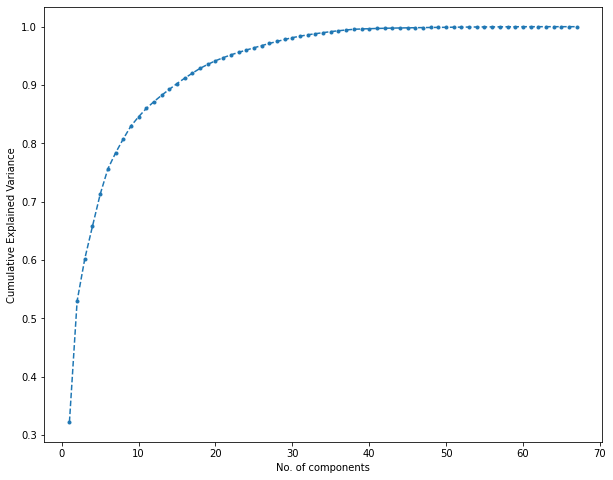

In [ ]:
#Cumulative Variance to identify how many PCA dimensions
plt.figure(figsize = (10,8))
plt.plot(range(1,68), pca.explained_variance_ratio_.cumsum(), marker = '.', linestyle = '--')
plt.xlabel('No. of components')
plt.ylabel('Cumulative Explained Variance')

In [ ]:
#The chart shows that 10 components explain 80% of the variance
pca=PCA(n_components=10)
pca.fit(baseline_norm_v3)
baseline_pca= pca.transform(baseline_norm_v3)

baseline_pca_df = pd.DataFrame(baseline_pca)
baseline_pca_df.columns=['P1','P2','P3','P4','P5','P6','P7','P8','P9','P10']

In [ ]:
#Append Components and Label to the dataframe
baseline_pca_labels_v3 = pd.concat([baseline_pca_v3_df.reset_index(drop= True), baseline_pca_df], axis = 1)

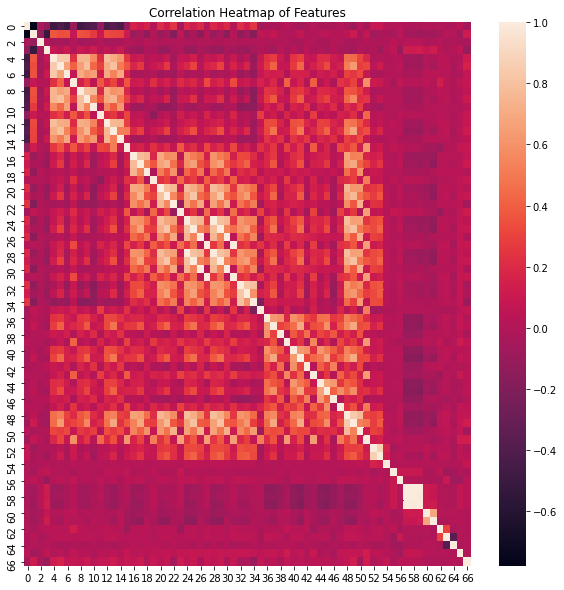

In [ ]:
#creating correlation heat map of raw baseline data
corrmat=np.corrcoef(baseline_v3.transpose())
plt.figure(figsize=[10,10])
plt.title(label='Correlation Heatmap of Features')
sns.heatmap(corrmat,xticklabels='auto',yticklabels='auto')

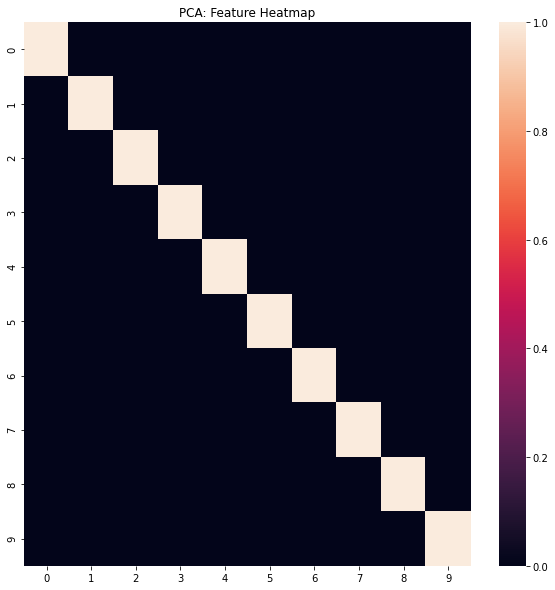

In [ ]:
# PCA correlation matrix
corrmat = np.corrcoef(baseline_pca_df.transpose())
plt.figure(figsize=[10,10])
plt.title(label='PCA: Feature Heatmap')
sns.heatmap(corrmat)

In [ ]:
corrmat = np.corrcoef(baseline_pca_labels_v3.transpose())
plt.figure(figsize=[20,20])
plt.title(label='Correlation Heatmap after PCA')
sns.heatmap(corrmat)


In [ ]:
plt.matshow(pca.components_,cmap='plasma')
plt.yticks([0,1,2,3,4,5,6,7,8,9],['P1','P2', 'P3','P4','P5','P6','P7','P8','P9','P10'],fontsize=10)
plt.colorbar()
plt.xticks(range(len(baseline_pca_labels_v3.columns)-13),baseline_pca_labels_v3.columns,rotation=65,ha='left')
#plt.tight_layout()
plt.show()# 

# PCA and K-means

In [ ]:
#Combine PCA and K-means to segment the data, using the PCA scores for the fit

PCAelbow = []
for k in range(1,20):
    kmeans_pca = KMeans(n_clusters=k, init = 'k-means++', random_state=42)
    kmeans_pca.fit(baseline_pca)
    PCAelbow.append(kmeans_pca.inertia_)

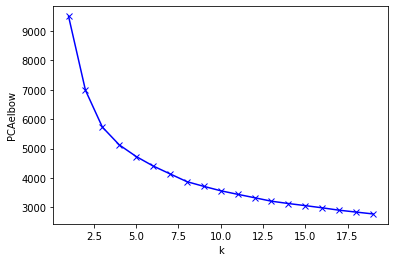

In [ ]:
plt.plot(range(1,20), PCAelbow, 'bx-')
plt.xlabel('k')
plt.ylabel('PCAelbow')
plt.show()

In [ ]:
# Run K-means with 4 clusters
kmeans_pca = KMeans(n_clusters=4, init= 'k-means++', random_state=42)
kmeans_pca.fit(baseline_pca)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [ ]:
#Append K-Means Label to the dataframe
from sklearn.metrics import silhouette_score 
from sklearn.metrics import davies_bouldin_score

#!pip install validclust
#from validclust.validclust import ValidClust

baseline_pca_labels_v3['KMeansSegment'] = kmeans_pca.labels_
baseline_v3['KMeansSegment'] = kmeans_pca.labels_
s_kmeans=silhouette_score(baseline_pca_df, kmeans_pca.labels_)
davies_s = davies_bouldin_score(baseline_pca_df,kmeans_pca.labels_)
print('Silhouette Score for K Means:', s_kmeans, davies_s)
#_dunn(baseline_norm_v2,kmeans_pca.labels_)

Silhouette Score for K Means: 0.1999477928750579 1.5795423006078309


In [ ]:
plt.figure(figsize = (10,8))

x_axis = baseline_pca_labels_v3.iloc[:, +67]
y_axis = baseline_pca_labels_v3.iloc[:, +68]

#x_axis = baseline_pca_labels.iloc[:, -1]
#y_axis = baseline_pca_labels.iloc[:, -9]

sns.scatterplot(x_axis,y_axis, hue=baseline_pca_labels_v3['KMeansSegment'], palette = ['g','r','c','b'])
plt.title("K-means: Clusters", fontsize=20)


<Figure size 432x288 with 0 Axes>

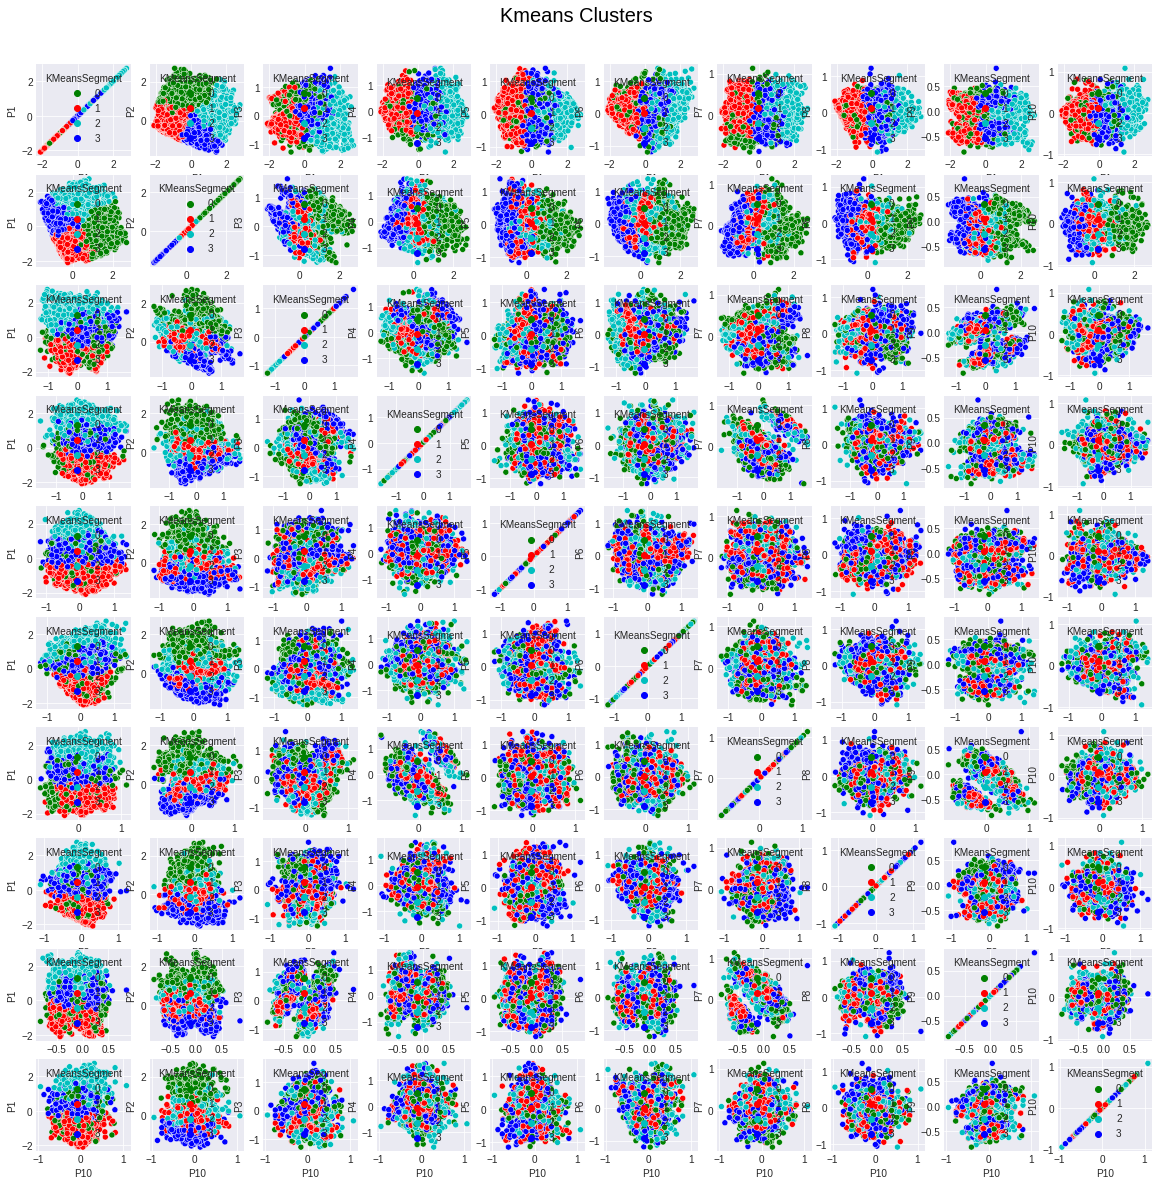

In [ ]:
import matplotlib.pyplot as plt

# Initialize the figure
plt.style.use('seaborn-darkgrid')
 
# create a color palette
palette = plt.get_cmap('Set1')
plt.tight_layout()
plt.subplots(5,5,figsize=(20,20))
plt.suptitle("Kmeans Clusters", fontsize=20, fontweight=4, color='black', x=0.5,y=0.92)

for rowx in range(1,11):
    for colx in range(1,11):
        plt.subplot(10,10,colx+(rowx-1)*10)
        xref=(66+rowx)
        yref=(66+colx)
        sns.scatterplot(baseline_pca_labels_v3.iloc[:, xref],baseline_pca_labels_v3.iloc[:, yref], hue=baseline_pca_labels_v3['KMeansSegment'], palette = ['g','r','c','b'])

plt.show()

# Hierarchical Clustering - Gower Method (with PCA)


In [ ]:

gd = gower.gower_matrix(baseline_pca_df)
Zd = linkage(gd,method = 'complete')
fig,axs = plt.subplots(1,1,figsize=(25,5))
#dn = dendrogram(Zd, truncate_mode='level',p=6,show_leaf_counts=True,ax=axs);
#print(f"Leaves = {len(dn['leaves'])}")

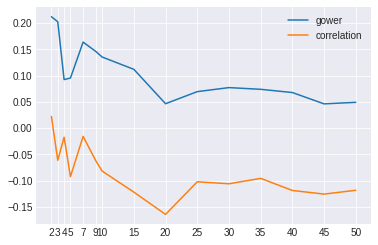

In [ ]:
# find k clusters
results = dict()

k_cand = [2,3,4,5,7,9,]
k_cand.extend(list(np.arange(10,55,5)))

for k in k_cand:
    cluster_array = fcluster(Zd, k, criterion='maxclust')
    score1 = silhouette_score(gd, cluster_array, metric='precomputed')
    score2 = silhouette_score(baseline_pca_df, cluster_array,metric='correlation')
    results[k] = {'k':cluster_array,'s1':score1,'s2' :score2}
    
plt.plot([i for i in results.keys()],[i['s1'] for i in results.values()],label='gower')
plt.plot([i for i in results.keys()],[i['s2'] for i in results.values()],label='correlation')
plt.legend()
plt.xticks(k_cand);


In [ ]:
baseline_pca_labels_v2['Gower_Kmedoids'] =results[4]['k']
gower_s = silhouette_score(baseline_pca_df,results[4]['k'])
print(gower_s)

0.10623664432084867


In [ ]:
plt.figure(figsize=(10,10))
plt.suptitle("Box plots: Q8", fontsize=20, fontweight=4, color='black', style='italic', x=0.5,y=0.92)

plt.subplot(1,3,1)
sns.boxplot(x='Gower_Kmedoids', y='Q8_Walking_median', data=baseline_pca_labels_v2)

plt.subplot(1,3,2)
sns.boxplot(x='Gower_Kmedoids', y='Q8_Walking_min', data=baseline_pca_labels_v2)

plt.subplot(1,3,3)
sns.boxplot(x='Gower_Kmedoids', y='Q8_Walking', data=baseline_pca_labels_v2)


In [ ]:
plt.figure(figsize=(10,10))
plt.suptitle("Box plots: ALSFRS scores", fontsize=20, fontweight=4, color='black', style='italic', x=0.5,y=0.92)

plt.subplot(1,3,1)
sns.boxplot(x='Gower_Kmedoids', y='ALSFRS_Slope', data=baseline_pca_labels_v2)

plt.subplot(1,3,2)
sns.boxplot(x='Gower_Kmedoids', y='ALSFRS_total_median', data=baseline_pca_labels_v2)

plt.subplot(1,3,3)
sns.boxplot(x='Gower_Kmedoids', y='ALSFRS_total_min', data=baseline_pca_labels_v2)

In [ ]:
import matplotlib.pyplot as plt

# Initialize the figure
plt.style.use('seaborn-darkgrid')
 
# create a color palette
palette = plt.get_cmap('Set1')
plt.tight_layout()
plt.subplots(10,10,figsize=(20,20))
plt.suptitle("PAM with Gower distance Clusters", fontsize=20, fontweight=4, color='black', style='italic', x=0.5,y=0.92)

for rowx in range(1,11):
    for colx in range(1,11):
        plt.subplot(10,10,colx+(rowx-1)*10)
        xref=(70+rowx)
        yref=(70+colx)
        sns.scatterplot(baseline_pca_labels_v2.iloc[:, xref],baseline_pca_labels_v2.iloc[:, yref], hue=baseline_pca_labels_v2['k-medoids-4'], palette = ['g','r','c','b'], legend=False)

plt.show()
        #plt.xlabel(x_axis)
        #plt.ylabel(y_axis)

# Hierarchical Clustering - Gower Method (without PCA)


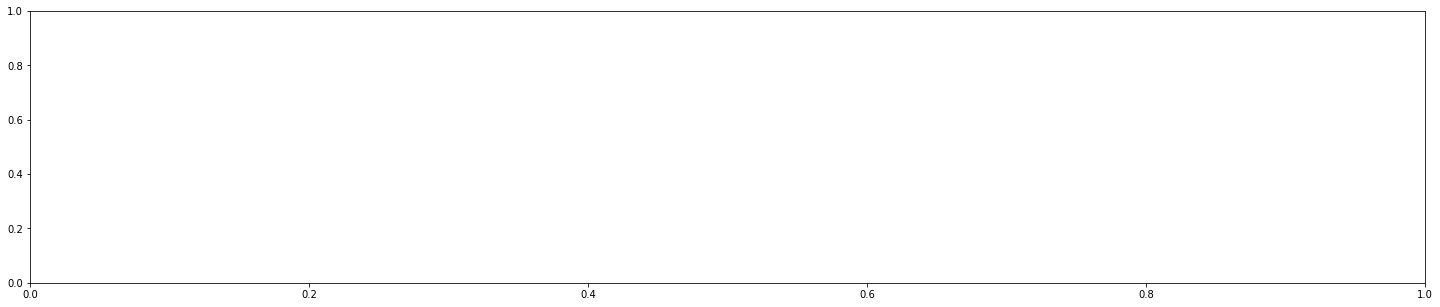

In [ ]:

gd = gower.gower_matrix(baseline_norm_v2)
Zd = linkage(gd,method = 'complete')
fig,axs = plt.subplots(1,1,figsize=(25,5))
#dn = dendrogram(Zd, truncate_mode='level',p=6,show_leaf_counts=True,ax=axs);
#print(f"Leaves = {len(dn['leaves'])}")

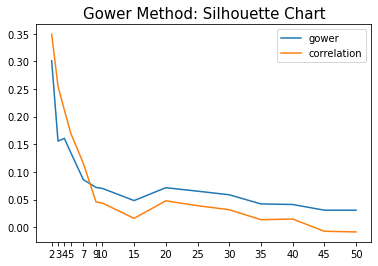

In [ ]:
# find k clusters
results = dict()

k_cand = [2,3,4,5,7,9,]
k_cand.extend(list(np.arange(10,55,5)))
plt.title("Gower Method: Silhouette Chart", fontsize=15)
for k in k_cand:
    cluster_array = fcluster(Zd, k, criterion='maxclust')
    score1 = silhouette_score(gd, cluster_array, metric='precomputed')
    score2 = silhouette_score(baseline_norm_v2, cluster_array,metric='correlation')
    results[k] = {'k':cluster_array,'s1':score1, 's2' :score2}
    
plt.plot([i for i in results.keys()],[i['s1'] for i in results.values()],label='gower')
plt.plot([i for i in results.keys()],[i['s2'] for i in results.values()],label='correlation')
plt.legend()
plt.xticks(k_cand);


In [ ]:
from sklearn.metrics import davies_bouldin_score 
baseline_pca_labels_v2['kmedoids_nopca'] =results[4]['k']
baseline_v2['kmedoids_nopca']=results[4]['k']
gower_s = silhouette_score(baseline_norm_v2,results[4]['k'])
davies_s = davies_bouldin_score(baseline_norm_v2,results[4]['k'])
print(gower_s)
print(davies_s)

0.13707502222745196
2.380393503072307


In [ ]:
baseline_v2.columns

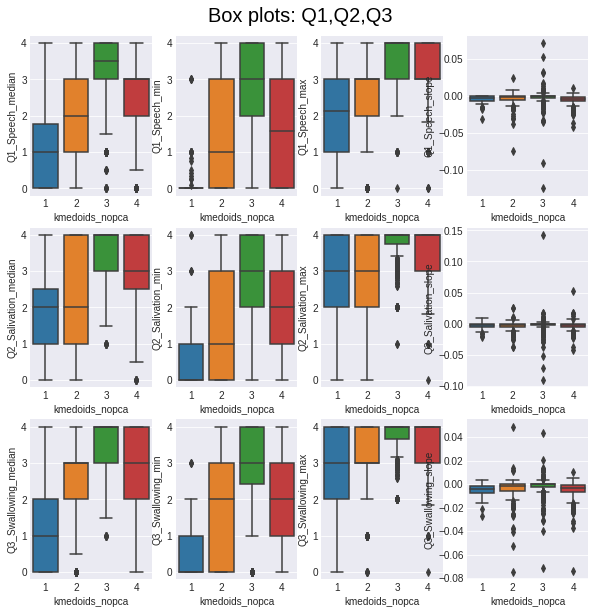

In [ ]:
plt.figure(figsize=(10,10))
plt.suptitle("Box plots: Q1,Q2,Q3", fontsize=20, fontweight=4, color='black', x=0.5,y=0.92)

plt.subplot(3,4,1)
sns.boxplot(x='kmedoids_nopca', y='Q1_Speech_median', data=baseline_v2)

plt.subplot(3,4,2)
sns.boxplot(x='kmedoids_nopca', y='Q1_Speech_min', data=baseline_v2)

plt.subplot(3,4,3)
sns.boxplot(x='kmedoids_nopca', y='Q1_Speech_max', data=baseline_v2)

plt.subplot(3,4,4)
sns.boxplot(x='kmedoids_nopca', y='Q1_Speech_slope', data=baseline_v2)

plt.subplot(3,4,5)
sns.boxplot(x='kmedoids_nopca', y='Q2_Salivation_median', data=baseline_v2)

plt.subplot(3,4,6)
sns.boxplot(x='kmedoids_nopca', y='Q2_Salivation_min', data=baseline_v2)

plt.subplot(3,4,7)
sns.boxplot(x='kmedoids_nopca', y='Q2_Salivation_max', data=baseline_v2)

plt.subplot(3,4,8)
sns.boxplot(x='kmedoids_nopca', y='Q2_Salivation_slope', data=baseline_v2)

plt.subplot(3,4,9)
sns.boxplot(x='kmedoids_nopca', y='Q3_Swallowing_median', data=baseline_v2)

plt.subplot(3,4,10)
sns.boxplot(x='kmedoids_nopca', y='Q3_Swallowing_min', data=baseline_v2)

plt.subplot(3,4,11)
sns.boxplot(x='kmedoids_nopca', y='Q3_Swallowing_max', data=baseline_v2)

plt.subplot(3,4,12)
sns.boxplot(x='kmedoids_nopca', y='Q3_Swallowing_slope', data=baseline_v2)



[Text(0, 0.5, 'Q3 Swallowing Median'), Text(0.5, 0, '')]

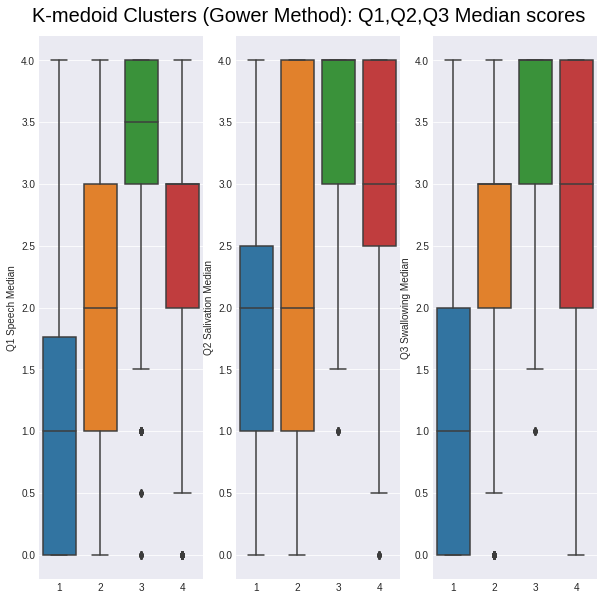

In [ ]:
plt.figure(figsize=(10,10))
plt.suptitle("K-medoid Clusters (Gower Method): Q1,Q2,Q3 Median scores", fontsize=20, fontweight=4, color='black', x=0.5,y=0.92)
plt.xlabel("Gower method: K-medoids clusters", fontsize=20, fontweight=4, color='black', x=0.5,y=0.01)

plt.subplot(1,3,1)
sns.boxplot(x='kmedoids_nopca', y='Q1_Speech_median', data=baseline_v2).set(xlabel='', ylabel='Q1 Speech Median')

plt.subplot(1,3,2)
sns.boxplot(x='kmedoids_nopca', y='Q2_Salivation_median', data=baseline_v2).set(xlabel='', ylabel='Q2 Salivation Median')

plt.subplot(1,3,3)
sns.boxplot(x='kmedoids_nopca', y='Q3_Swallowing_median', data=baseline_v2).set(xlabel='', ylabel='Q3 Swallowing Median')

[Text(0, 0.5, 'Q3 Swallowing Slope'), Text(0.5, 0, '')]

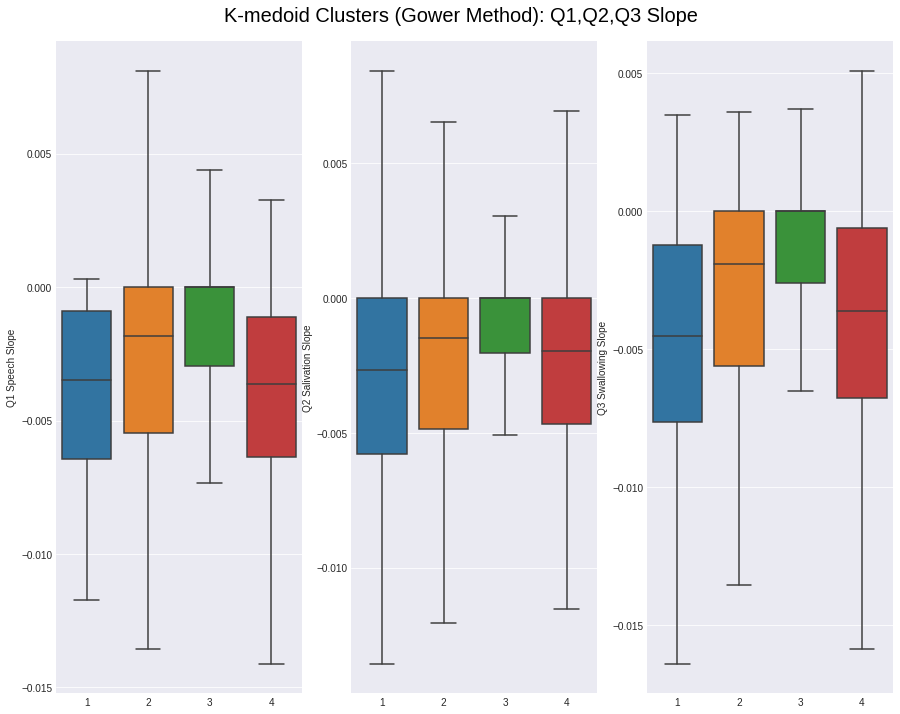

In [ ]:
plt.figure(figsize=(15,12))
plt.suptitle("K-medoid Clusters (Gower Method): Q1,Q2,Q3 Slope", fontsize=20, fontweight=4, color='black', x=0.5,y=0.92)
plt.xlabel("Gower method: K-medoids clusters", fontsize=20, fontweight=4, color='black', x=0.5,y=0.01)
plt.tight_layout

plt.subplot(1,3,1)
sns.boxplot(x='kmedoids_nopca', y='Q1_Speech_slope', data=baseline_v2, showfliers=False).set(xlabel='', ylabel='Q1 Speech Slope')

plt.subplot(1,3,2)
sns.boxplot(x='kmedoids_nopca', y='Q2_Salivation_slope', data=baseline_v2, showfliers=False).set(xlabel='', ylabel='Q2 Salivation Slope')

plt.subplot(1,3,3)
sns.boxplot(x='kmedoids_nopca', y='Q3_Swallowing_slope', data=baseline_v2, showfliers=False).set(xlabel='', ylabel='Q3 Swallowing Slope')

[Text(0, 0.5, 'ALSFRS Min'), Text(0.5, 0, '')]

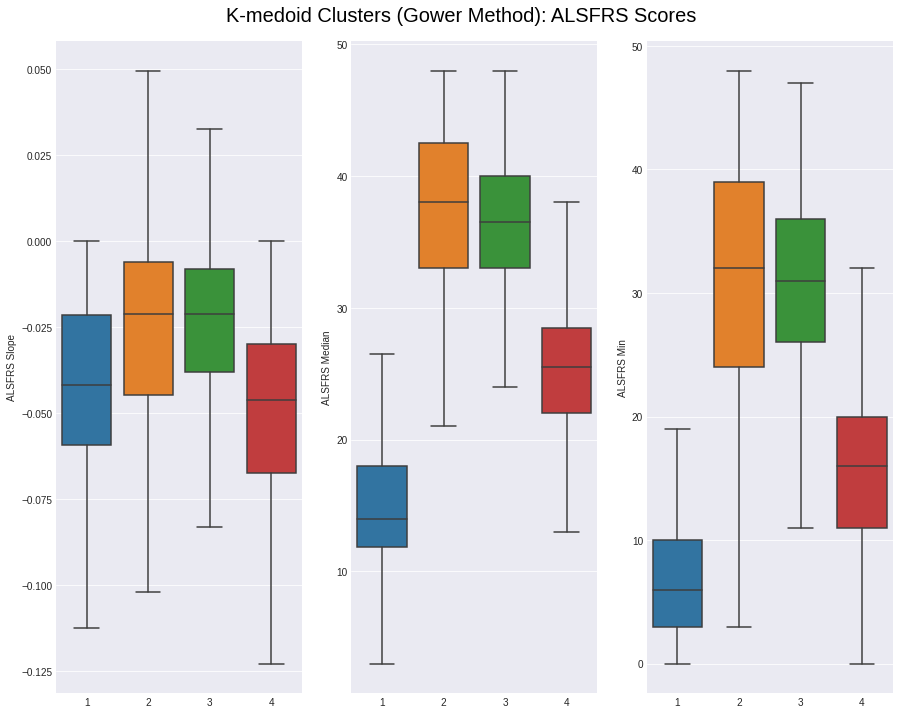

In [ ]:

plt.figure(figsize=(15,12))
plt.suptitle("K-medoid Clusters (Gower Method): ALSFRS Scores", fontsize=20, fontweight=4, color='black', x=0.5,y=0.92)
plt.xlabel("Gower method: K-medoids clusters", fontsize=20, fontweight=4, color='black', x=0.5,y=0.01)
plt.tight_layout

plt.subplot(1,3,1)
sns.boxplot(x='kmedoids_nopca', y='ALSFRS_Slope', data=baseline_v2, showfliers=False).set(xlabel='', ylabel='ALSFRS Slope')

plt.subplot(1,3,2)
sns.boxplot(x='kmedoids_nopca', y='ALSFRS_total_median', data=baseline_v2, showfliers=False).set(xlabel='', ylabel='ALSFRS Median')

plt.subplot(1,3,3)
sns.boxplot(x='kmedoids_nopca', y='ALSFRS_total_min', data=baseline_v2, showfliers=False).set(xlabel='', ylabel='ALSFRS Min')

In [ ]:
baseline_v2.columns

Index(['Site_of_Onset___Bulbar', 'Site_of_Onset___Limb',
       'Site_of_Onset___Limb_and_Bulbar', 'Site_of_Onset___Other',
       'Q1_Speech_median', 'Q1_Speech_min', 'Q1_Speech_max', 'Q1_Speech_slope',
       'Q2_Salivation_median', 'Q2_Salivation_min', 'Q2_Salivation_max',
       'Q2_Salivation_slope', 'Q3_Swallowing_median', 'Q3_Swallowing_min',
       'Q3_Swallowing_max', 'Q3_Swallowing_slope', 'Q4_Handwriting_median',
       'Q4_Handwriting_min', 'Q4_Handwriting_max', 'Q4_Handwriting_slope',
       'Q6_Dressing_and_Hygiene_median', 'Q6_Dressing_and_Hygiene_min',
       'Q6_Dressing_and_Hygiene_max', 'Q6_Dressing_and_Hygiene_slope',
       'Q7_Turning_in_Bed_median', 'Q7_Turning_in_Bed_min',
       'Q7_Turning_in_Bed_max', 'Q7_Turning_in_Bed', 'Q8_Walking_median',
       'Q8_Walking_min', 'Q8_Walking_max', 'Q8_Walking',
       'Q9_Climbing_Stairs_median', 'Q9_Climbing_Stairs_min',
       'Q9_Climbing_Stairs_max', 'Q9_Climbing_Stairs_Slope',
       'R_1_Dyspnea_median', 'R_1_Dyspne

In [ ]:
import matplotlib.pyplot as plt

# Initialize the figure
plt.style.use('seaborn-darkgrid')
 
# create a color palette
palette = plt.get_cmap('Set1')
plt.tight_layout()
plt.subplots(70,70,figsize=(25,20))
plt.suptitle("K-medoids with Gower Distance", fontsize=20, fontweight=4, color='black', x=0.5,y=0.92)

for rowx in range(1,72):
    for colx in range(1,72):
        plt.subplot(70,70,colx+(rowx-1)*10)
        xref=(rowx-1)
        yref=(colx-1)
        #x_val = baseline_pca_labels_v2.iloc[:, xref]
        #y_val = baseline_pca_labels_v2.iloc[:, yref]
        sns.scatterplot(baseline_v2.iloc[:, xref],baseline_v2.iloc[:, yref], hue=baseline_v2['kmedoids_nopca'], palette = ['g','r','c','b'], legend=False)

plt.show()
        #plt.xlabel(x_axis)
        #plt.ylabel(y_axis)

In [ ]:
plt.figure(figsize = (10,8))

x_axis = baseline_pca_labels_v2.iloc[:, +51]
y_axis = baseline_pca_labels_v2.iloc[:, +69]

#x_axis = baseline_pca_labels.iloc[:, -1]
#y_axis = baseline_pca_labels.iloc[:, -9]

sns.scatterplot(x_axis,y_axis, hue=baseline_v2['kmedoids_nopca'], palette = ['g','r','c','b'])
plt.title("K-means: Clusters", fontsize=20)


# Hierarchical Clustering - Gower Method (DataSubset)


In [ ]:
baseline_subset=pd.DataFrame(baseline_v2.iloc[:, [48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70]])
baseline_subsetV2=pd.DataFrame(baseline_subset.iloc[:,[0,1,2,3,4,5,6,7,8,9,10,11,16,17,18,19,20,21,22]])
#baseline_subsetV3=pd.DataFrame(baseline_subset.iloc[:,[0,1,2,3,4,5,6,7,8,9,10,11,16,17,18,19,20,21,22]])

In [ ]:
scaler = MinMaxScaler()
baseline_norm_ss = scaler.fit_transform(baseline_subsetV2)
pd.DataFrame(baseline_norm_ss).describe()
baseline_norm_ss_df = pd.DataFrame(baseline_norm_ss, columns=baseline_subsetV2.columns)

In [ ]:

gd = gower.gower_matrix(baseline_norm_ss)
Zd = linkage(gd,method = 'ward')
fig,axs = plt.subplots(1,1,figsize=(25,5))
dn = dendrogram(Zd, truncate_mode='level',p=6,show_leaf_counts=True,ax=axs);
print(f"Leaves = {len(dn['leaves'])}")

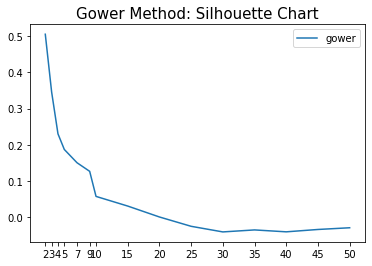

In [ ]:
# find k clusters
results = dict()

k_cand = [2,3,4,5,7,9,]
k_cand.extend(list(np.arange(10,55,5)))
plt.title("Gower Method: Silhouette Chart", fontsize=15)
for k in k_cand:
    cluster_array = fcluster(Zd, k, criterion='maxclust')
    score1 = silhouette_score(gd, cluster_array, metric='precomputed')
    score2 = silhouette_score(baseline_norm_ss, cluster_array,metric='correlation')
    results[k] = {'k':cluster_array,'s1':score1, 's2' :score2}
    
plt.plot([i for i in results.keys()],[i['s1'] for i in results.values()],label='gower')
#plt.plot([i for i in results.keys()],[i['s2'] for i in results.values()],label='correlation')
plt.legend()
plt.xticks(k_cand);


In [ ]:
from sklearn.metrics import davies_bouldin_score 
baseline_norm_ss_df['kmedoids_nopca'] =results[4]['k']
baseline_subset['kmedoids_nopca']=results[4]['k']
baseline_v2['kmedoids_ss']=results[4]['k']
gower_s = silhouette_score(baseline_norm_ss,results[4]['k'])
print(gower_s)

0.3428742574416276
1.1058122033919133


In [ ]:
baseline_v2['kmedoids_4']=results[4]['k']
baseline_subsetV2['kmedoids_4']=results[4]['k']

In [ ]:
baseline_v2.loc[baseline_v2['kmedoids_4'] == 1, 'ClusterName'] = 'Med-Low Risk'
baseline_v2.loc[baseline_v2['kmedoids_4'] == 2, 'ClusterName'] = 'High Risk'
baseline_v2.loc[baseline_v2['kmedoids_4'] == 3, 'ClusterName'] = 'Med-High Risk'
baseline_v2.loc[baseline_v2['kmedoids_4'] == 4, 'ClusterName'] = 'Low Risk'

In [ ]:
baseline_subsetV2.loc[baseline_v2['kmedoids_4'] == 1, 'ClusterName'] = 'Med-Low Risk'
baseline_subsetV2.loc[baseline_v2['kmedoids_4'] == 2, 'ClusterName'] = 'High Risk'
baseline_subsetV2.loc[baseline_v2['kmedoids_4'] == 3, 'ClusterName'] = 'Med-High Risk'
baseline_subsetV2.loc[baseline_v2['kmedoids_4'] == 4, 'ClusterName'] = 'Low Risk'

In [ ]:
baseline_v2.groupby('kmedoids_4').count()

Site_of_Onset___Bulbar  ...  ClusterName
kmedoids_4                          ...             
1                              602  ...          602
2                              758  ...          758
3                             1163  ...         1163
4                             1219  ...         1219

[4 rows x 73 columns]

[Text(0, 0.5, 'ALSFRS Scores'), Text(0.5, 0, '')]

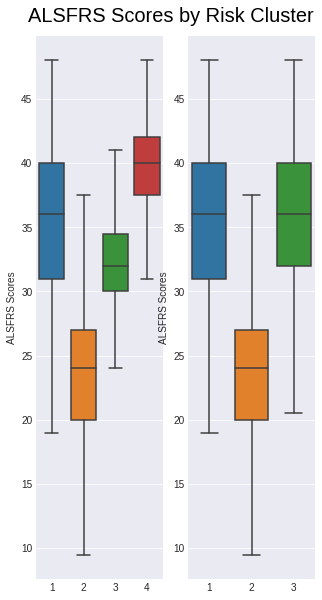

In [ ]:
plt.figure(figsize=(5,10))
plt.suptitle("ALSFRS Scores by Risk Cluster", fontsize=20, fontweight=4, color='black', x=0.5,y=0.92)
plt.xlabel("Gower method: K-medoids clusters", fontsize=20, fontweight=4, color='black', x=0.5,y=0.01)
#my_col = {"Low Risk": "green", "Medium Risk": "orange", "High Risk":"red"}

plt.subplot(1,2,1)
sns.boxplot(x='kmedoids_4', y='ALSFRS_total_median', data=baseline_v2, showfliers=False).set(xlabel='', ylabel='ALSFRS Scores')

plt.subplot(1,2,2)
sns.boxplot(x='kmedoids_ss', y='ALSFRS_total_median', data=baseline_v2, showfliers=False).set(xlabel='', ylabel='ALSFRS Scores')

In [ ]:
#Output data cuts for analysis and insights
baseline_v2.groupby('kmedoids_4').median().reset_index().to_csv('median_groupby.csv')
baseline_v2.groupby('kmedoids_4').mean().reset_index().to_csv('mean_groupby.csv')
baseline_v2.groupby('kmedoids_4').min().reset_index().to_csv('min_groupby.csv')
baseline_v2.groupby('kmedoids_4').max().reset_index().to_csv('max_groupby.csv')
baseline_v2.groupby('kmedoids_4').Site_of_Onset___Bulbar.value_counts().to_csv('Bulbar_mode')
baseline_v2.groupby('kmedoids_4').Site_of_Onset___Limb.value_counts().to_csv('Limb_mode')
baseline_v2.groupby('kmedoids_4').Site_of_Onset___Limb_and_Bulbar.value_counts().to_csv('LimbBulbar_mode')
baseline_v2.groupby('kmedoids_4').Site_of_Onset___Other.value_counts().to_csv('Other_mode')
baseline_v2.to_csv('cluster_scores_4.csv')
baseline_pca_labels_v2.to_csv('cluster_pca_scores_4.csv')

[Text(0, 0.5, 'Q9 Climbing Stairs'), Text(0.5, 0, '')]

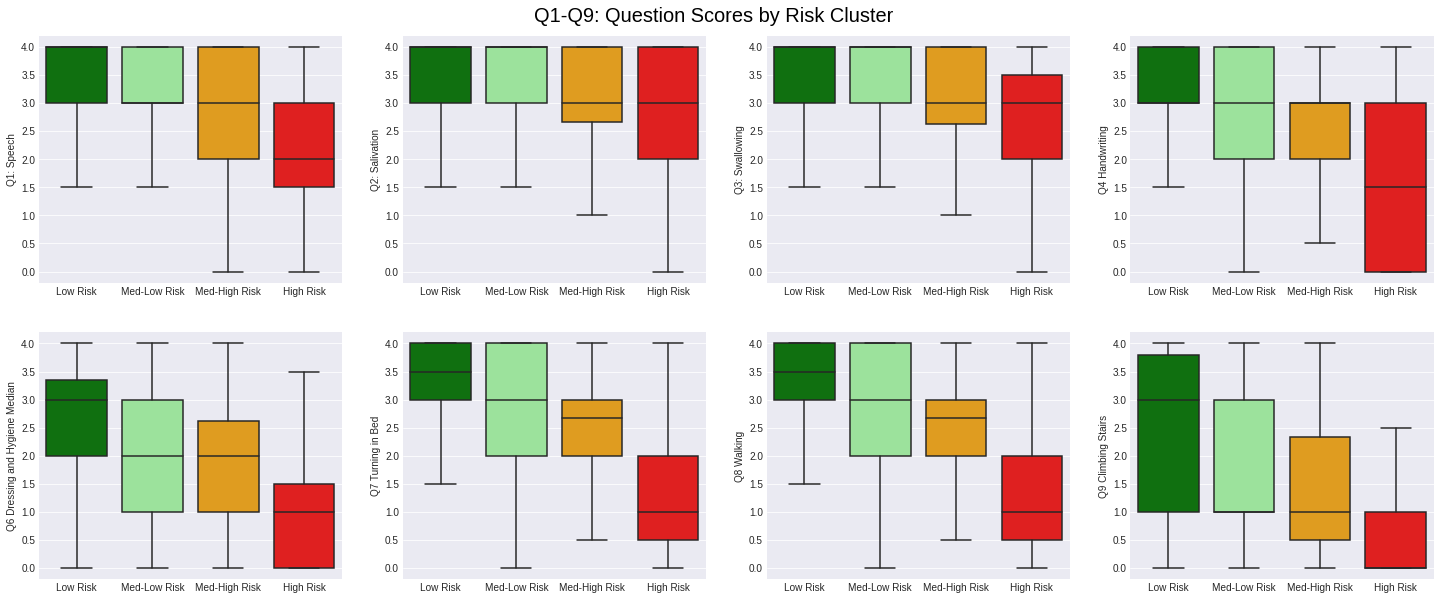

In [ ]:
plt.figure(figsize=(25,10))
plt.suptitle("Q1-Q9: Question Scores by Risk Cluster", fontsize=20, fontweight=4, color='black', x=0.5,y=0.92)
my_col = {"Low Risk": "green", "Med-Low Risk": "lightgreen", "Med-High Risk": "orange","High Risk":"red"}

plt.subplot(2,4,1)
ax1=sns.boxplot(x='ClusterName', y='Q1_Speech_median', data=baseline_v2, order=["Low Risk", "Med-Low Risk", "Med-High Risk", "High Risk"], showfliers=False, palette=my_col).set(xlabel='', ylabel='Q1: Speech')
#ax1.set_edgecolor(None)


plt.subplot(2,4,2)
sns.boxplot(x='ClusterName', y='Q2_Salivation_median', data=baseline_v2, order=["Low Risk", "Med-Low Risk", "Med-High Risk", "High Risk"], palette=my_col, showfliers=False).set(xlabel='', ylabel='Q2: Salivation')

plt.subplot(2,4,3)
sns.boxplot(x='ClusterName', y='Q3_Swallowing_median', data=baseline_v2, showfliers=False, order=["Low Risk", "Med-Low Risk", "Med-High Risk", "High Risk"], palette=my_col).set(xlabel='', ylabel='Q3: Swallowing')

plt.subplot(2,4,4)
sns.boxplot(x='ClusterName', y='Q4_Handwriting_median', data=baseline_v2, order=["Low Risk", "Med-Low Risk", "Med-High Risk", "High Risk"], showfliers=False, palette=my_col).set(xlabel='', ylabel='Q4 Handwriting')

plt.subplot(2,4,5)
sns.boxplot(x='ClusterName', y='Q6_Dressing_and_Hygiene_median', data=baseline_v2, order=["Low Risk", "Med-Low Risk", "Med-High Risk", "High Risk"], showfliers=False, palette=my_col).set(xlabel='', ylabel='Q6 Dressing and Hygiene Median')

plt.subplot(2,4,6)
sns.boxplot(x='ClusterName', y='Q7_Turning_in_Bed_median', data=baseline_v2, order=["Low Risk", "Med-Low Risk", "Med-High Risk","High Risk"], palette=my_col, showfliers=False).set(xlabel='', ylabel='Q7 Turning in Bed')

plt.subplot(2,4,7)
sns.boxplot(x='ClusterName', y='Q8_Walking_median', data=baseline_v2, showfliers=False, order=["Low Risk", "Med-Low Risk", "Med-High Risk", "High Risk"], palette=my_col).set(xlabel='', ylabel='Q8 Walking')

plt.subplot(2,4,8)
sns.boxplot(x='ClusterName', y='Q9_Climbing_Stairs_median', data=baseline_v2, order=["Low Risk", "Med-Low Risk", "Med-High Risk", "High Risk"], palette=my_col, showfliers=False).set(xlabel='', ylabel='Q9 Climbing Stairs')

[Text(0, 0.5, 'ALSFRS Scores'), Text(0.5, 0, '')]

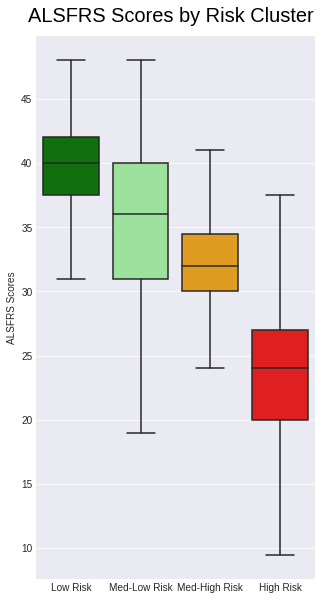

In [ ]:
plt.figure(figsize=(5,10))
plt.suptitle("ALSFRS Scores by Risk Cluster", fontsize=20, fontweight=4, color='black', x=0.5,y=0.92)
my_col = {"Low Risk": "green", "Med-Low Risk": "lightgreen", "Med-High Risk": "orange","High Risk":"red"}

plt.subplot(1,1,1)
sns.boxplot(x='ClusterName', y='ALSFRS_total_median', data=baseline_v2, order=["Low Risk", "Med-Low Risk", "Med-High Risk", "High Risk"], showfliers=False, palette=my_col).set(xlabel='', ylabel='ALSFRS Scores')


In [ ]:
from scipy.stats import ttest_ind

cat1 = baseline_v2['ALSFRS_total_median'][baseline_v2.kmedoids_4==1]
cat2 = baseline_v2['ALSFRS_total_median'][baseline_v2.kmedoids_4==2]
cat3 = baseline_v2['ALSFRS_total_median'][baseline_v2.kmedoids_4==3]
cat4 = baseline_v2['ALSFRS_total_median'][baseline_v2.kmedoids_4==3]

print('ALSFRS_total Median', 'Cat1-Cat2', ttest_ind(cat1, cat2),'Cat2-Cat3',ttest_ind(cat2,cat3),'Cat1-Cat3',ttest_ind(cat1,cat3))

cat1 = baseline_v2['Q8_Walking_median'][baseline_v2.kmedoids_4==1]
cat2 = baseline_v2['Q8_Walking_median'][baseline_v2.kmedoids_4==2]
cat3 = baseline_v2['Q8_Walking_median'][baseline_v2.kmedoids_4==3]
cat4 = baseline_v2['Q8_Walking_median'][baseline_v2.kmedoids_4==3]

print('ALSFRS_total Median', 'Cat1-Cat2', ttest_ind(cat1, cat2),'Cat2-Cat3',ttest_ind(cat2,cat3),'Cat1-Cat3',ttest_ind(cat1,cat3))


ALSFRS_total Median Cat1-Cat2 Ttest_indResult(statistic=35.63925422561526, pvalue=6.148037806680945e-197) Cat2-Cat3 Ttest_indResult(statistic=-40.78780428581993, pvalue=1.899215758766159e-262) Cat1-Cat3 Ttest_indResult(statistic=13.929538114832422, pvalue=6.400903048299914e-42)
ALSFRS_total Median Cat1-Cat2 Ttest_indResult(statistic=25.30360640466233, pvalue=4.745428661957681e-116) Cat2-Cat3 Ttest_indResult(statistic=-28.538325077833054, pvalue=1.2911609864979033e-149) Cat1-Cat3 Ttest_indResult(statistic=5.833770945416495, pvalue=6.433301020525254e-09)


Text(0.5, 1.0, 'Hierarchical Clusters with k-medoids on Gower Distance matrix')

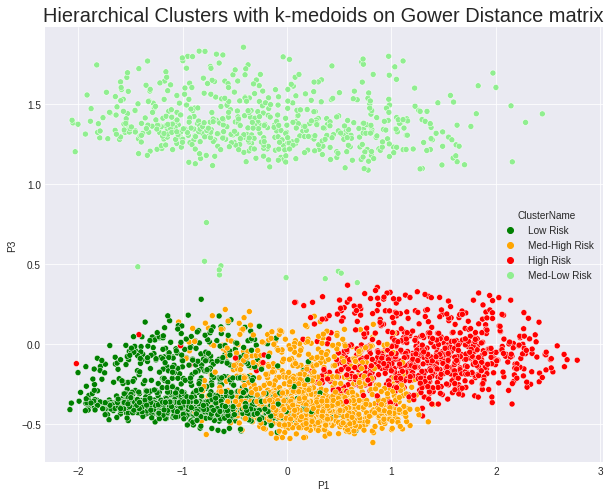

In [ ]:
plt.figure(figsize = (10,8))

x_axis = baseline_v2.iloc[:, +72]
y_axis = baseline_v2.iloc[:, +74]

#x_axis = baseline_pca_labels.iloc[:, -1]
#y_axis = baseline_pca_labels.iloc[:, -9]

sns.scatterplot(x_axis,y_axis, hue=baseline_v2['ClusterName'], palette = my_col)
plt.title("Hierarchical Clusters with k-medoids on Gower Distance matrix", fontsize=20)


In [ ]:
import matplotlib.pyplot as plt

# Initialize the figure
plt.style.use('seaborn-darkgrid')
 
# create a color palette
palette = plt.get_cmap('Set1')
plt.tight_layout()
plt.subplots(19,19,figsize=(25,20))
plt.suptitle("K-medoids with Gower Distance", fontsize=20, fontweight=4, color='black', x=0.5,y=0.92)

for rowx in range(1,20):
    for colx in range(1,20):
        plt.subplot(19,19,colx+(rowx-1)*19)
        xref=(0+rowx)
        yref=(0+colx)
        #x_val = baseline_pca_labels_v2.iloc[:, xref]
        #y_val = baseline_pca_labels_v2.iloc[:, yref]
        sns.scatterplot(baseline_subsetV2.iloc[:, xref],baseline_subsetV2.iloc[:, yref], hue=baseline_subsetV2['ClusterName'], palette = my_col, legend=False)

plt.show()
        #plt.xlabel(x_axis)
        #plt.ylabel(y_axis)

# Hierarchical Clustering - Minkowski Method (with PCA)

In [ ]:
!pip install pyclustering
from pyclustering.cluster.kmedoids import kmedoids
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

In [ ]:

PCA_minkowski = squareform(pdist(baseline_pca_df, 'minkowski'))
Minkowski_Zd = linkage(PCA_minkowski,method = 'complete')

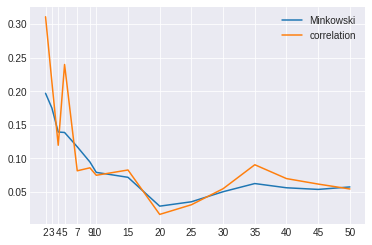

In [ ]:
# find k clusters
results = dict()

k_cand = [2,3,4,5,7,9,]
k_cand.extend(list(np.arange(10,55,5)))

for k in k_cand:
    cluster_array = fcluster(Minkowski_Zd, k, criterion='maxclust')
    score1 = silhouette_score(PCA_minkowski, cluster_array, metric='precomputed')
    score2 = silhouette_score(PCA_minkowski, cluster_array,metric='correlation')
    results[k] = {'k':cluster_array,'s1':score1,'s2':score2}
    
plt.plot([i for i in results.keys()],[i['s1'] for i in results.values()],label='Minkowski')
plt.plot([i for i in results.keys()],[i['s2'] for i in results.values()],label='correlation')
plt.legend()
plt.xticks(k_cand);


In [ ]:
baseline_pca_labels_v2['Minkowski'] =results[4]['k']
minkowski_s = silhouette_score(baseline_pca_df,results[4]['k'])
print(minkowski_s)

0.13934850301771934


# Hierarchical Clustering - Minkowski Method (without PCA)

In [ ]:
!pip install pyclustering
from pyclustering.cluster.kmedoids import kmedoids
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

In [ ]:

Norm_minkowski = squareform(pdist(baseline_norm_v2, 'minkowski'))
Minkowski_Zd = linkage(Norm_minkowski,method = 'complete')

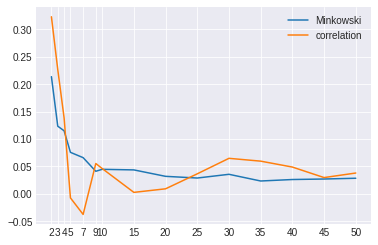

In [ ]:
# find k clusters
results = dict()

k_cand = [2,3,4,5,7,9,]
k_cand.extend(list(np.arange(10,55,5)))

for k in k_cand:
    cluster_array = fcluster(Minkowski_Zd, k, criterion='maxclust')
    score1 = silhouette_score(Norm_minkowski, cluster_array, metric='precomputed')
    score2 = silhouette_score(Norm_minkowski, cluster_array,metric='correlation')
    results[k] = {'k':cluster_array,'s1':score1,'s2':score2}
    
plt.plot([i for i in results.keys()],[i['s1'] for i in results.values()],label='Minkowski')
plt.plot([i for i in results.keys()],[i['s2'] for i in results.values()],label='correlation')
plt.legend()
plt.xticks(k_cand);


In [ ]:
model = AgglomerativeClustering(affinity='precomputed', n_clusters=4, linkage='complete').fit(Norm_minkowski)
ac_minkowski=silhouette_score(baseline_norm_v2,model.labels_)
print(ac_minkowski)

0.0842763051467006


# Hierarchical Clustering - Minkowski Method (Datasubset)

In [ ]:
!pip install pyclustering
from pyclustering.cluster.kmedoids import kmedoids
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

In [ ]:

Norm_minkowski = squareform(pdist(baseline_subsetV3, 'minkowski'))
Minkowski_Zd = linkage(Norm_minkowski,method = 'complete')

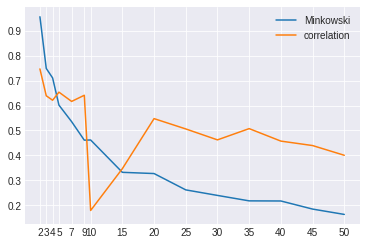

In [ ]:
# find k clusters
results = dict()

k_cand = [2,3,4,5,7,9,]
k_cand.extend(list(np.arange(10,55,5)))

for k in k_cand:
    cluster_array = fcluster(Minkowski_Zd, k, criterion='maxclust')
    score1 = silhouette_score(Norm_minkowski, cluster_array, metric='precomputed')
    score2 = silhouette_score(Norm_minkowski, cluster_array,metric='correlation')
    results[k] = {'k':cluster_array,'s1':score1,'s2':score2}
    
plt.plot([i for i in results.keys()],[i['s1'] for i in results.values()],label='Minkowski')
plt.plot([i for i in results.keys()],[i['s2'] for i in results.values()],label='correlation')
plt.legend()
plt.xticks(k_cand);


In [ ]:
model = AgglomerativeClustering(affinity='precomputed', n_clusters=3, linkage='complete').fit(Norm_minkowski)
ac_minkowski=silhouette_score(baseline_subset,model.labels_)
print(ac_minkowski)
baseline_v2['Minkowski']=model.labels_

0.013762110389934957


In [ ]:
baseline_v2.groupby('Minkowski').count()

# GMM - (with PCA)

In [ ]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=4).fit(baseline_pca)
gmm_labels=gmm.predict(baseline_pca)
baseline_pca_labels_v2['GMMLabels'] = gmm_labels
s_gmm=silhouette_score(baseline_pca_df,gmm_labels)
print(s_gmm)

0.07381722253721364


In [ ]:
import matplotlib.pyplot as plt

# Initialize the figure
plt.style.use('seaborn-darkgrid')
 
# create a color palette
palette = plt.get_cmap('Set1')
plt.tight_layout()
plt.subplots(5,5,figsize=(20,20))
plt.suptitle("GMM Clusters", fontsize=20, fontweight=4, color='black', style='italic', x=0.5,y=0.92)

for rowx in range(1,6):
    for colx in range(1,6):
        plt.subplot(5,5,colx+(rowx-1)*5)
        xref=(rowx-12)
        yref=(colx-12)
        #x_val = baseline_pca_labels_v2.iloc[:, xref]
        #y_val = baseline_pca_labels_v2.iloc[:, yref]
        sns.scatterplot(baseline_pca_labels_v2.iloc[:, xref],baseline_pca_labels_v2.iloc[:, yref], hue=baseline_pca_labels_v2['GMMLabels'], palette = ['g','r','c','b'])

plt.show()
        #plt.xlabel(x_axis)
        #plt.ylabel(y_axis)

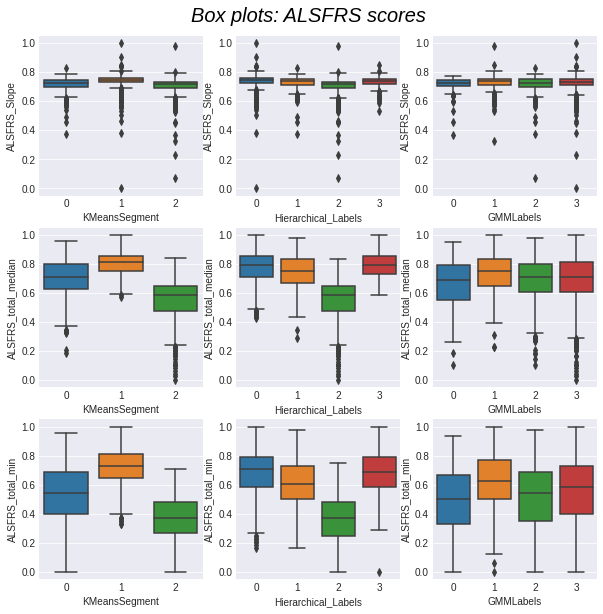

In [ ]:
plt.figure(figsize=(10,10))
plt.suptitle("Box plots: ALSFRS scores", fontsize=20, fontweight=4, color='black', style='italic', x=0.5,y=0.92)

plt.subplot(3,3,1)
sns.boxplot(x='KMeansSegment', y='ALSFRS_Slope', data=baseline_pca_labels_v2)

plt.subplot(3,3,2)
sns.boxplot(x='Hierarchical_Labels', y='ALSFRS_Slope', data=baseline_pca_labels_v2)

plt.subplot(3,3,3)
sns.boxplot(x='GMMLabels', y='ALSFRS_Slope', data=baseline_pca_labels_v2)

plt.subplot(3,3,4)
sns.boxplot(x='KMeansSegment', y='ALSFRS_total_median', data=baseline_pca_labels_v2)

plt.subplot(3,3,5)
sns.boxplot(x='Hierarchical_Labels', y='ALSFRS_total_median', data=baseline_pca_labels_v2)

plt.subplot(3,3,6)
sns.boxplot(x='GMMLabels', y='ALSFRS_total_median', data=baseline_pca_labels_v2)

plt.subplot(3,3,7)
sns.boxplot(x='KMeansSegment', y='ALSFRS_total_min', data=baseline_pca_labels_v2)

plt.subplot(3,3,8)
sns.boxplot(x='Hierarchical_Labels', y='ALSFRS_total_min', data=baseline_pca_labels_v2)

plt.subplot(3,3,9)
sns.boxplot(x='GMMLabels', y='ALSFRS_total_min', data=baseline_pca_labels_v2)


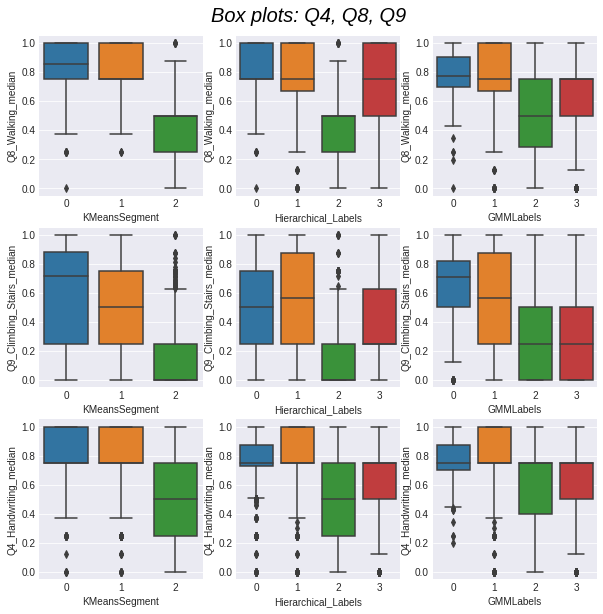

In [ ]:
plt.figure(figsize=(10,10))
plt.suptitle("Box plots: Q4, Q8, Q9", fontsize=20, fontweight=4, color='black', style='italic', x=0.5,y=0.92)

plt.subplot(3,3,1)
sns.boxplot(x='KMeansSegment', y='Q8_Walking_median', data=baseline_pca_labels_v2)

plt.subplot(3,3,2)
sns.boxplot(x='Hierarchical_Labels', y='Q8_Walking_median', data=baseline_pca_labels_v2)

plt.subplot(3,3,3)
sns.boxplot(x='GMMLabels', y='Q8_Walking_median', data=baseline_pca_labels_v2)

plt.subplot(3,3,4)
sns.boxplot(x='KMeansSegment', y='Q9_Climbing_Stairs_median', data=baseline_pca_labels_v2)

plt.subplot(3,3,5)
sns.boxplot(x='Hierarchical_Labels', y='Q9_Climbing_Stairs_median', data=baseline_pca_labels_v2)

plt.subplot(3,3,6)
sns.boxplot(x='GMMLabels', y='Q9_Climbing_Stairs_median', data=baseline_pca_labels_v2)

plt.subplot(3,3,7)
sns.boxplot(x='KMeansSegment', y='Q4_Handwriting_median', data=baseline_pca_labels_v2)

plt.subplot(3,3,8)
sns.boxplot(x='Hierarchical_Labels', y='Q4_Handwriting_median', data=baseline_pca_labels_v2)

plt.subplot(3,3,9)
sns.boxplot(x='GMMLabels', y='Q4_Handwriting_median', data=baseline_pca_labels_v2)

# GMM  - (without PCA)

In [ ]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=4).fit(baseline_norm_v2)
gmm_labels=gmm.predict(baseline_norm_v2)
baseline_pca_labels_v2['GMMLabels'] = gmm_labels
s_gmm=silhouette_score(baseline_norm_v2,gmm_labels)
print(s_gmm)

-0.014498769684685804


In [ ]:
import matplotlib.pyplot as plt

# Initialize the figure
plt.style.use('seaborn-darkgrid')
 
# create a color palette
palette = plt.get_cmap('Set1')
plt.tight_layout()
plt.subplots(5,5,figsize=(20,20))
plt.suptitle("GMM Clusters", fontsize=20, fontweight=4, color='black', style='italic', x=0.5,y=0.92)

for rowx in range(1,6):
    for colx in range(1,6):
        plt.subplot(5,5,colx+(rowx-1)*5)
        xref=(rowx-12)
        yref=(colx-12)
        #x_val = baseline_pca_labels_v2.iloc[:, xref]
        #y_val = baseline_pca_labels_v2.iloc[:, yref]
        sns.scatterplot(baseline_pca_labels_v2.iloc[:, xref],baseline_pca_labels_v2.iloc[:, yref], hue=baseline_pca_labels_v2['GMMLabels'], palette = ['g','r','c','b'])

plt.show()
        #plt.xlabel(x_axis)
        #plt.ylabel(y_axis)

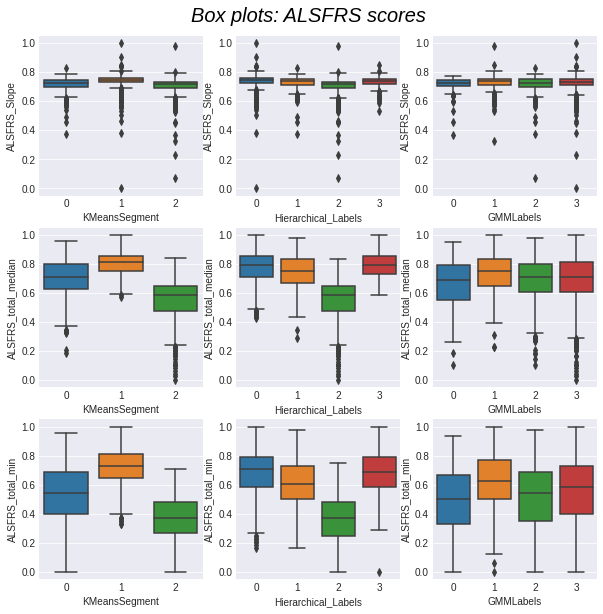

In [ ]:
plt.figure(figsize=(10,10))
plt.suptitle("Box plots: ALSFRS scores", fontsize=20, fontweight=4, color='black', style='italic', x=0.5,y=0.92)

plt.subplot(3,3,1)
sns.boxplot(x='KMeansSegment', y='ALSFRS_Slope', data=baseline_pca_labels_v2)

plt.subplot(3,3,2)
sns.boxplot(x='Hierarchical_Labels', y='ALSFRS_Slope', data=baseline_pca_labels_v2)

plt.subplot(3,3,3)
sns.boxplot(x='GMMLabels', y='ALSFRS_Slope', data=baseline_pca_labels_v2)

plt.subplot(3,3,4)
sns.boxplot(x='KMeansSegment', y='ALSFRS_total_median', data=baseline_pca_labels_v2)

plt.subplot(3,3,5)
sns.boxplot(x='Hierarchical_Labels', y='ALSFRS_total_median', data=baseline_pca_labels_v2)

plt.subplot(3,3,6)
sns.boxplot(x='GMMLabels', y='ALSFRS_total_median', data=baseline_pca_labels_v2)

plt.subplot(3,3,7)
sns.boxplot(x='KMeansSegment', y='ALSFRS_total_min', data=baseline_pca_labels_v2)

plt.subplot(3,3,8)
sns.boxplot(x='Hierarchical_Labels', y='ALSFRS_total_min', data=baseline_pca_labels_v2)

plt.subplot(3,3,9)
sns.boxplot(x='GMMLabels', y='ALSFRS_total_min', data=baseline_pca_labels_v2)


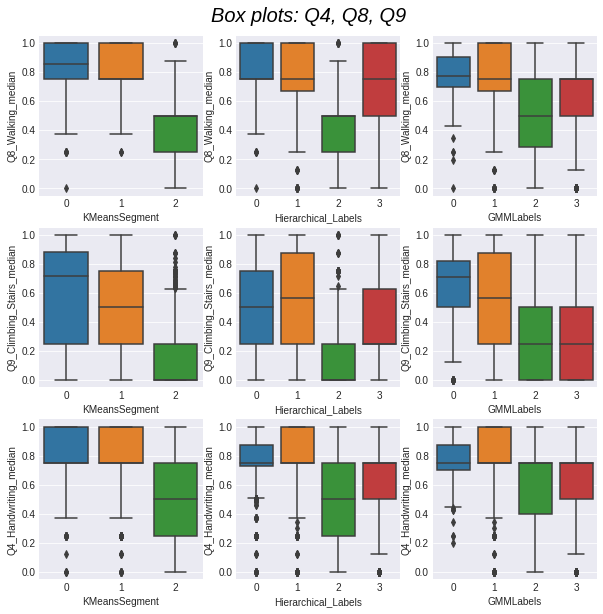

In [ ]:
plt.figure(figsize=(10,10))
plt.suptitle("Box plots: Q4, Q8, Q9", fontsize=20, fontweight=4, color='black', style='italic', x=0.5,y=0.92)

plt.subplot(3,3,1)
sns.boxplot(x='KMeansSegment', y='Q8_Walking_median', data=baseline_pca_labels_v2)

plt.subplot(3,3,2)
sns.boxplot(x='Hierarchical_Labels', y='Q8_Walking_median', data=baseline_pca_labels_v2)

plt.subplot(3,3,3)
sns.boxplot(x='GMMLabels', y='Q8_Walking_median', data=baseline_pca_labels_v2)

plt.subplot(3,3,4)
sns.boxplot(x='KMeansSegment', y='Q9_Climbing_Stairs_median', data=baseline_pca_labels_v2)

plt.subplot(3,3,5)
sns.boxplot(x='Hierarchical_Labels', y='Q9_Climbing_Stairs_median', data=baseline_pca_labels_v2)

plt.subplot(3,3,6)
sns.boxplot(x='GMMLabels', y='Q9_Climbing_Stairs_median', data=baseline_pca_labels_v2)

plt.subplot(3,3,7)
sns.boxplot(x='KMeansSegment', y='Q4_Handwriting_median', data=baseline_pca_labels_v2)

plt.subplot(3,3,8)
sns.boxplot(x='Hierarchical_Labels', y='Q4_Handwriting_median', data=baseline_pca_labels_v2)

plt.subplot(3,3,9)
sns.boxplot(x='GMMLabels', y='Q4_Handwriting_median', data=baseline_pca_labels_v2)

In [ ]:
baseline_pca_labels_v2.columns

In [ ]:
from sklearn import datasets 
from sklearn.cluster import KMeans 
from sklearn.metrics import davies_bouldin_score 
from sklearn.datasets.samples_generator import make_blobs 

#print(davies_bouldin_score(baseline_pca_labels_v2, baseline_pca_labels_v2['KMeansSegment'])) 
#print(davies_bouldin_score(baseline_pca_labels_v2, baseline_pca_labels_v2['Hierarchical_Labels']))
print(silhouette_score(baseline_pca_labels_v2, baseline_pca_labels_v2['GMMLabels']))  

# GMM (Datasubset)

In [ ]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=4).fit(baseline_subset)
gmm_labels=gmm.predict(baseline_subset)
baseline_v2['GMMLabels'] = gmm_labels
s_gmm=silhouette_score(baseline_norm_v2,gmm_labels)
print(s_gmm)

0.022919739323331786


In [ ]:
import matplotlib.pyplot as plt

# Initialize the figure
plt.style.use('seaborn-darkgrid')
 
# create a color palette
palette = plt.get_cmap('Set1')
plt.tight_layout()
plt.subplots(5,5,figsize=(20,20))
plt.suptitle("GMM Clusters", fontsize=20, fontweight=4, color='black', style='italic', x=0.5,y=0.92)

for rowx in range(1,6):
    for colx in range(1,6):
        plt.subplot(5,5,colx+(rowx-1)*5)
        xref=(rowx-12)
        yref=(colx-12)
        #x_val = baseline_pca_labels_v2.iloc[:, xref]
        #y_val = baseline_pca_labels_v2.iloc[:, yref]
        sns.scatterplot(baseline_pca_labels_v2.iloc[:, xref],baseline_pca_labels_v2.iloc[:, yref], hue=baseline_pca_labels_v2['GMMLabels'], palette = ['g','r','c','b'])

plt.show()
        #plt.xlabel(x_axis)
        #plt.ylabel(y_axis)

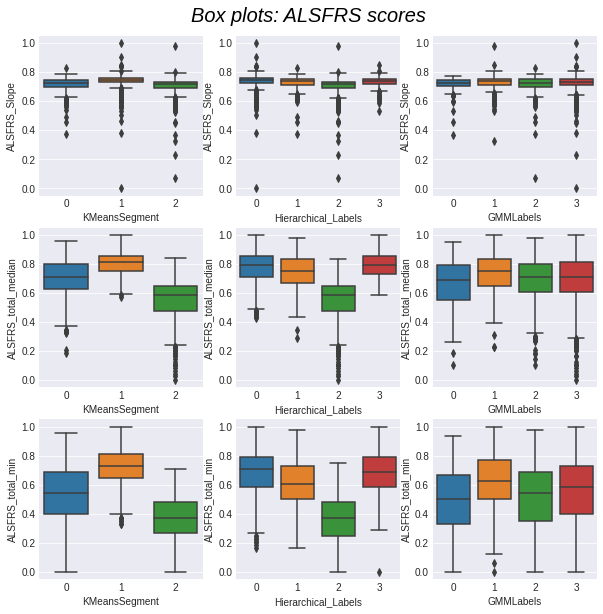

In [ ]:
plt.figure(figsize=(10,10))
plt.suptitle("Box plots: ALSFRS scores", fontsize=20, fontweight=4, color='black', style='italic', x=0.5,y=0.92)

plt.subplot(3,3,1)
sns.boxplot(x='KMeansSegment', y='ALSFRS_Slope', data=baseline_pca_labels_v2)

plt.subplot(3,3,2)
sns.boxplot(x='Hierarchical_Labels', y='ALSFRS_Slope', data=baseline_pca_labels_v2)

plt.subplot(3,3,3)
sns.boxplot(x='GMMLabels', y='ALSFRS_Slope', data=baseline_pca_labels_v2)

plt.subplot(3,3,4)
sns.boxplot(x='KMeansSegment', y='ALSFRS_total_median', data=baseline_pca_labels_v2)

plt.subplot(3,3,5)
sns.boxplot(x='Hierarchical_Labels', y='ALSFRS_total_median', data=baseline_pca_labels_v2)

plt.subplot(3,3,6)
sns.boxplot(x='GMMLabels', y='ALSFRS_total_median', data=baseline_pca_labels_v2)

plt.subplot(3,3,7)
sns.boxplot(x='KMeansSegment', y='ALSFRS_total_min', data=baseline_pca_labels_v2)

plt.subplot(3,3,8)
sns.boxplot(x='Hierarchical_Labels', y='ALSFRS_total_min', data=baseline_pca_labels_v2)

plt.subplot(3,3,9)
sns.boxplot(x='GMMLabels', y='ALSFRS_total_min', data=baseline_pca_labels_v2)


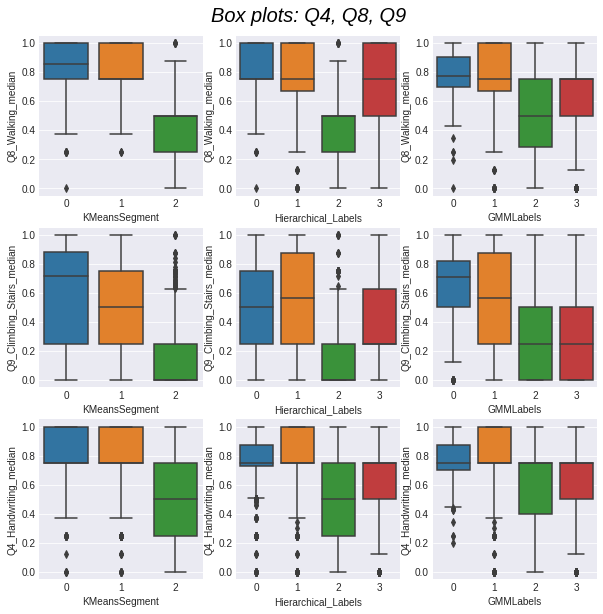

In [ ]:
plt.figure(figsize=(10,10))
plt.suptitle("Box plots: Q4, Q8, Q9", fontsize=20, fontweight=4, color='black', style='italic', x=0.5,y=0.92)

plt.subplot(3,3,1)
sns.boxplot(x='KMeansSegment', y='Q8_Walking_median', data=baseline_pca_labels_v2)

plt.subplot(3,3,2)
sns.boxplot(x='Hierarchical_Labels', y='Q8_Walking_median', data=baseline_pca_labels_v2)

plt.subplot(3,3,3)
sns.boxplot(x='GMMLabels', y='Q8_Walking_median', data=baseline_pca_labels_v2)

plt.subplot(3,3,4)
sns.boxplot(x='KMeansSegment', y='Q9_Climbing_Stairs_median', data=baseline_pca_labels_v2)

plt.subplot(3,3,5)
sns.boxplot(x='Hierarchical_Labels', y='Q9_Climbing_Stairs_median', data=baseline_pca_labels_v2)

plt.subplot(3,3,6)
sns.boxplot(x='GMMLabels', y='Q9_Climbing_Stairs_median', data=baseline_pca_labels_v2)

plt.subplot(3,3,7)
sns.boxplot(x='KMeansSegment', y='Q4_Handwriting_median', data=baseline_pca_labels_v2)

plt.subplot(3,3,8)
sns.boxplot(x='Hierarchical_Labels', y='Q4_Handwriting_median', data=baseline_pca_labels_v2)

plt.subplot(3,3,9)
sns.boxplot(x='GMMLabels', y='Q4_Handwriting_median', data=baseline_pca_labels_v2)

In [ ]:
baseline_pca_labels_v2.columns

In [ ]:
from sklearn import datasets 
from sklearn.cluster import KMeans 
from sklearn.metrics import davies_bouldin_score 
from sklearn.datasets.samples_generator import make_blobs 

#print(davies_bouldin_score(baseline_pca_labels_v2, baseline_pca_labels_v2['KMeansSegment'])) 
#print(davies_bouldin_score(baseline_pca_labels_v2, baseline_pca_labels_v2['Hierarchical_Labels']))
print(silhouette_score(baseline_pca_labels_v2, baseline_pca_labels_v2['GMMLabels']))  

# Hierarchical Clustering

In [ ]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.decomposition import PCA 
from sklearn.cluster import AgglomerativeClustering 
from sklearn.preprocessing import StandardScaler, normalize 
from sklearn.metrics import silhouette_score 
import scipy.cluster.hierarchy as shc 
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [ ]:
scaler = MinMaxScaler()
baseline_HC_norm_v2 = scaler.fit_transform(baseline_v2)
pd.DataFrame(baseline_HC_norm_v2).describe()

In [ ]:
#X_scaled_df = pd.DataFrame(X_scaled,columns=X.columns)
baseline_HC_scaled = pd.DataFrame(baseline_HC_norm_v2, columns=baseline_v2.columns)  

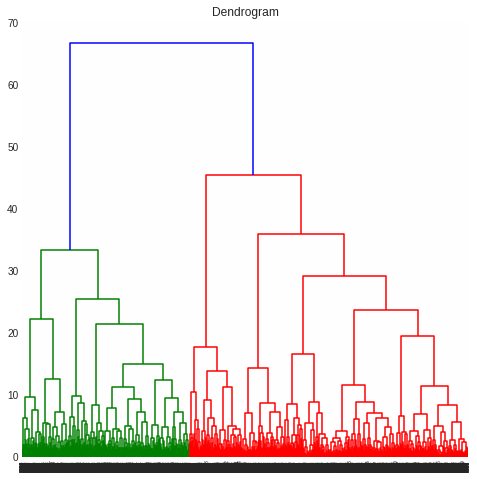

In [ ]:
pca=PCA(n_components=10)
pca.fit(baseline_HC_norm_v2)

pca = PCA(n_components = 10) 
HC_principal = pca.fit_transform(baseline_HC_norm_v2) 
HC_principal = pd.DataFrame(HC_principal) 
HC_principal.columns = ['P1','P2','P3','P4','P5','P6','P7','P8','P9','P10']

plt.figure(figsize =(8, 8)) 
plt.title('Dendrogram') 
cl_mergings = shc.linkage(HC_principal, method="ward")
Dendrogram = dendrogram(cl_mergings)
#Dendrogram = shc.dendrogram((shc.linkage(X_principal, method ='ward')))



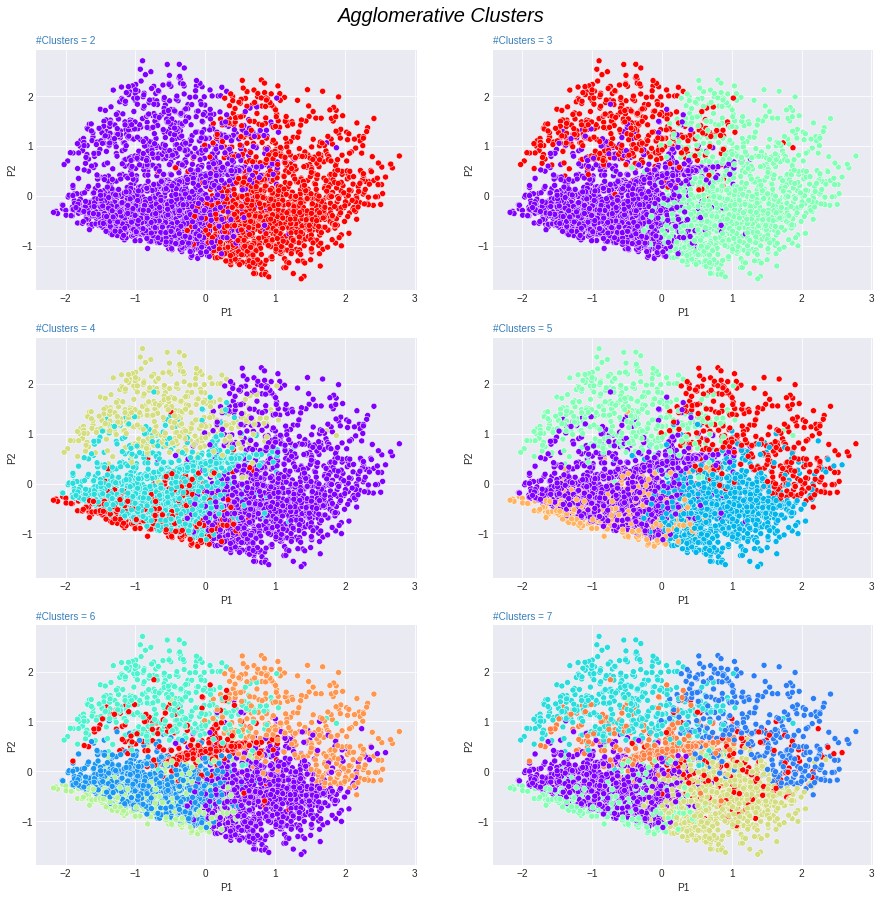

In [ ]:
ac2 = AgglomerativeClustering(n_clusters = 2) 
ac3 = AgglomerativeClustering(n_clusters = 3) 
ac4 = AgglomerativeClustering(n_clusters = 4) 
ac5 = AgglomerativeClustering(n_clusters = 5) 
ac6 = AgglomerativeClustering(n_clusters = 6) 
ac7 = AgglomerativeClustering(n_clusters = 7) 

# Initialize the figure
plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(15,15))

# create a color palette
palette = plt.get_cmap('Set1')
plt.tight_layout()
#fig, ax = plt.subplots(2, 3, sharex='col', sharey='row')
#plt.subplots(3,2,figsize=(15,15))
plt.suptitle("Agglomerative Clusters", fontsize=20, fontweight=4, color='black', style='italic', x=0.5,y=0.92)

plt.subplot(3,2,1)
plt.title('#Clusters = 2', loc='left', fontsize=10, fontweight=0, color=palette(1) )
sns.scatterplot(HC_principal['P1'], HC_principal['P2'],c = ac2.fit_predict(HC_principal), cmap ='rainbow') 

plt.subplot(3,2,2)
plt.title('#Clusters = 3', loc='left', fontsize=10, fontweight=0, color=palette(1) )
#ax[0,0].(figsize =(6, 6)) 
sns.scatterplot(HC_principal['P1'], HC_principal['P2'],c = ac3.fit_predict(HC_principal), cmap ='rainbow') 

plt.subplot(3,2,3)
plt.title('#Clusters = 4', loc='left', fontsize=10, fontweight=0, color=palette(1) )
#ax[0,0].(figsize =(6, 6)) 
sns.scatterplot(HC_principal['P1'], HC_principal['P2'],c = ac4.fit_predict(HC_principal), cmap ='rainbow') 

plt.subplot(3,2,4)
plt.title('#Clusters = 5', loc='left', fontsize=10, fontweight=0, color=palette(1) )
#ax[0,0].(figsize =(6, 6)) 
sns.scatterplot(HC_principal['P1'], HC_principal['P2'],c = ac5.fit_predict(HC_principal), cmap ='rainbow') 

plt.subplot(3,2,5)
plt.title('#Clusters = 6', loc='left', fontsize=10, fontweight=0, color=palette(1) )
#ax[0,0].(figsize =(6, 6)) 
sns.scatterplot(HC_principal['P1'], HC_principal['P2'],c = ac6.fit_predict(HC_principal), cmap ='rainbow') 

plt.subplot(3,2,6)
plt.title('#Clusters = 7', loc='left', fontsize=10, fontweight=0, color=palette(1) )
#ax[0,0].(figsize =(6, 6)) 
sns.scatterplot(HC_principal['P1'], HC_principal['P2'],c = ac7.fit_predict(HC_principal), cmap ='rainbow') 

# Axis title
#plt.xlabel(0, 0.5, 'Month', ha='center', va='center')
#plt.ylabel(0,0.5, 'ALSFRS Score', ha='center', va='center', rotation='vertical')


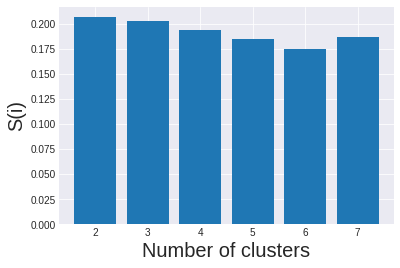

In [ ]:
k = [2, 3, 4, 5, 6, 7] 

# Appending the silhouette scores of the different models to the list 
silhouette_scores = [] 
silhouette_scores.append( 
		silhouette_score(HC_principal, ac2.fit_predict(HC_principal))) 
silhouette_scores.append( 
		silhouette_score(HC_principal, ac3.fit_predict(HC_principal))) 
silhouette_scores.append( 
		silhouette_score(HC_principal, ac4.fit_predict(HC_principal))) 
silhouette_scores.append( 
		silhouette_score(HC_principal, ac5.fit_predict(HC_principal))) 
silhouette_scores.append( 
		silhouette_score(HC_principal, ac6.fit_predict(HC_principal))) 
silhouette_scores.append( 
		silhouette_score(HC_principal, ac7.fit_predict(HC_principal))) 

# Plotting a bar graph to compare the results 
plt.bar(k, silhouette_scores) 
plt.xlabel('Number of clusters', fontsize = 20) 
plt.ylabel('S(i)', fontsize = 20) 
plt.show() 


In [ ]:
Hier_Cluster_Labels=cut_tree(cl_mergings,n_clusters=4).reshape(-1,)
hc_score=silhouette_score(baseline_pca_df,Hier_Cluster_Labels)
print(hc_score)

0.19308043054937837


In [ ]:
#Append Components and Label to the dataframe
baseline_HC_labels_v2 = pd.concat([baseline_HC_scaled.reset_index(drop= True), pd.DataFrame(HC_principal)], axis = 1)
baseline_HC_labels_v2['Hierarchical_Labels'] = Hier_Cluster_Labels

#Add Hierarchical Labels to baseline_pca_labels_v2
baseline_pca_labels_v2['Hierarchical_Labels'] = Hier_Cluster_Labels

<Figure size 432x288 with 0 Axes>

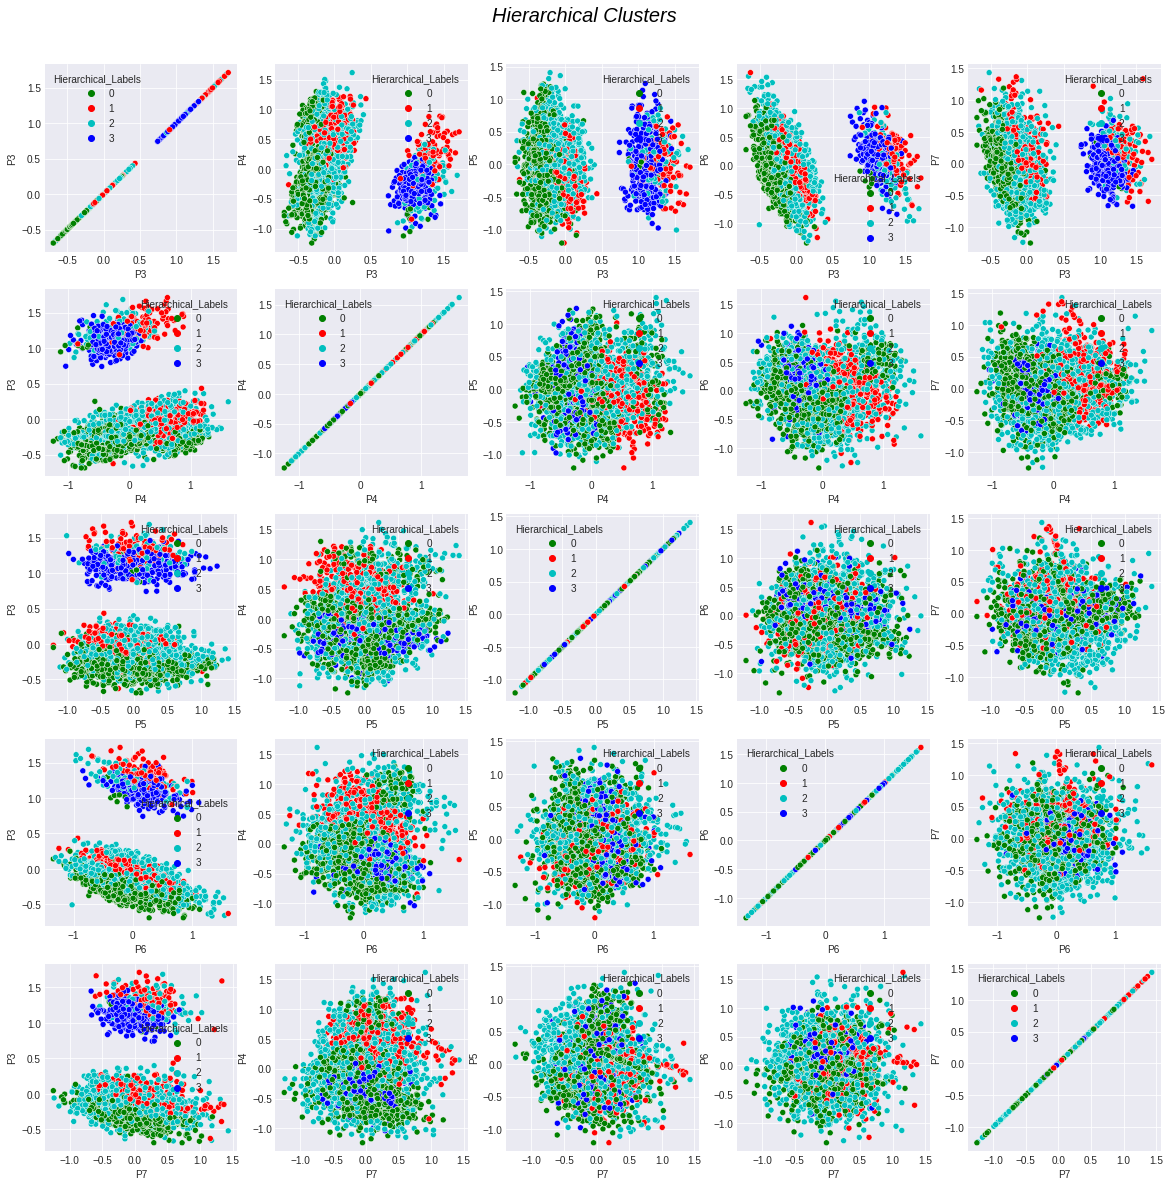

In [ ]:
import matplotlib.pyplot as plt

# Initialize the figure
plt.style.use('seaborn-darkgrid')
 
# create a color palette
palette = plt.get_cmap('Set1')
plt.tight_layout()
plt.subplots(5,5,figsize=(20,20))
plt.suptitle("Hierarchical Clusters", fontsize=20, fontweight=4, color='black', style='italic', x=0.5,y=0.92)

for rowx in range(1,6):
    for colx in range(1,6):
        plt.subplot(5,5,colx+(rowx-1)*5)
        xref=(rowx-12)
        yref=(colx-12)
        #x_val = baseline_pca_labels_v2.iloc[:, xref]
        #y_val = baseline_pca_labels_v2.iloc[:, yref]
        sns.scatterplot(baseline_pca_labels_v2.iloc[:, xref],baseline_pca_labels_v2.iloc[:, yref], hue=baseline_pca_labels_v2['Hierarchical_Labels'], palette = ['g','r','c','b'])

plt.show()
        #plt.xlabel(x_axis)
        #plt.ylabel(y_axis)

In [ ]:
plt.matshow(pca.components_,cmap='viridis')
plt.yticks([0,1,2,3,4,5,6,7,8],['Comp0','Comp1', 'Comp2','Comp3','Comp4','Comp5','Comp6','Comp7'],fontsize=10)
plt.colorbar()
plt.xticks(range(len(baseline_HC_labels_v2.columns)),baseline_HC_labels_v2.columns,rotation=65,ha='left')
#plt.tight_layout()
plt.show()# 

# Hierarchical Clustering - No PCA

In [ ]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.decomposition import PCA 
from sklearn.cluster import AgglomerativeClustering 
from sklearn.preprocessing import StandardScaler, normalize 
from sklearn.metrics import silhouette_score 
import scipy.cluster.hierarchy as shc 
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [ ]:
scaler = MinMaxScaler()
baseline_HC_norm_v2 = scaler.fit_transform(baseline_v2)
pd.DataFrame(baseline_HC_norm_v2).describe()

In [ ]:
#X_scaled_df = pd.DataFrame(X_scaled,columns=X.columns)
baseline_HC_scaled = pd.DataFrame(baseline_HC_norm_v2, columns=baseline_v2.columns)  

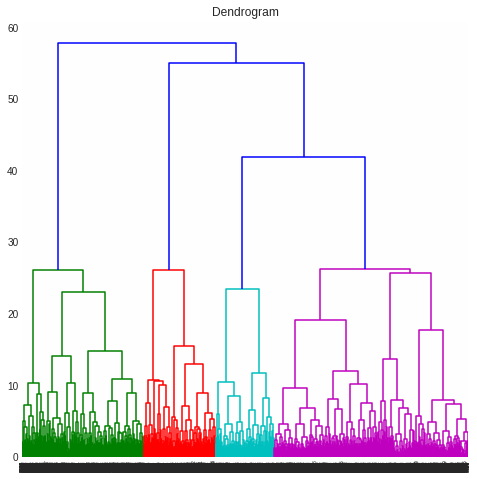

In [ ]:

plt.figure(figsize =(8, 8)) 
plt.title('Dendrogram') 
cl_mergings = shc.linkage(baseline_HC_norm_v2, method="ward")
Dendrogram = dendrogram(cl_mergings)
#Dendrogram = shc.dendrogram((shc.linkage(X_principal, method ='ward')))



In [ ]:
baseline_HC_scaled.columns

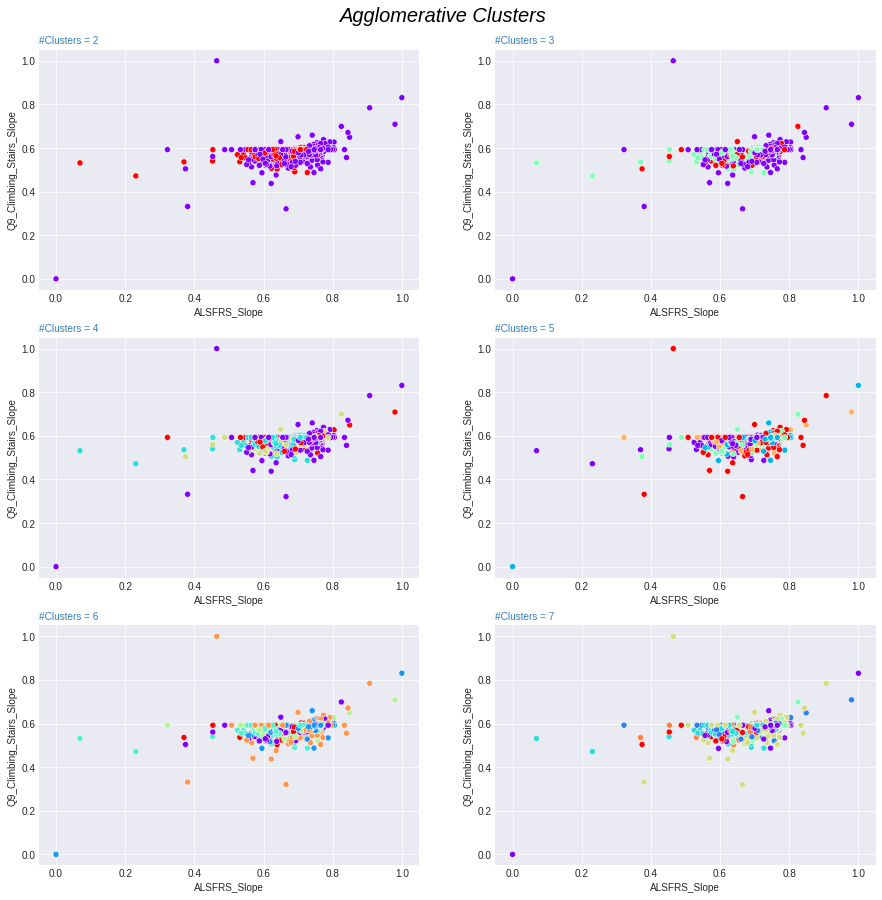

In [ ]:
ac2 = AgglomerativeClustering(n_clusters = 2) 
ac3 = AgglomerativeClustering(n_clusters = 3) 
ac4 = AgglomerativeClustering(n_clusters = 4) 
ac5 = AgglomerativeClustering(n_clusters = 5) 
ac6 = AgglomerativeClustering(n_clusters = 6) 
ac7 = AgglomerativeClustering(n_clusters = 7) 

# Initialize the figure
plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(15,15))

# create a color palette
palette = plt.get_cmap('Set1')
plt.tight_layout()
#fig, ax = plt.subplots(2, 3, sharex='col', sharey='row')
#plt.subplots(3,2,figsize=(15,15))
plt.suptitle("Agglomerative Clusters", fontsize=20, fontweight=4, color='black', style='italic', x=0.5,y=0.92)

plt.subplot(3,2,1)
plt.title('#Clusters = 2', loc='left', fontsize=10, fontweight=0, color=palette(1) )
sns.scatterplot(baseline_HC_scaled['ALSFRS_Slope'], baseline_HC_scaled['Q9_Climbing_Stairs_Slope'],c = ac2.fit_predict(baseline_HC_norm_v2), cmap ='rainbow') 

plt.subplot(3,2,2)
plt.title('#Clusters = 3', loc='left', fontsize=10, fontweight=0, color=palette(1) )
#ax[0,0].(figsize =(6, 6)) 
sns.scatterplot(baseline_HC_scaled['ALSFRS_Slope'], baseline_HC_scaled['Q9_Climbing_Stairs_Slope'],c = ac3.fit_predict(baseline_HC_norm_v2), cmap ='rainbow') 

plt.subplot(3,2,3)
plt.title('#Clusters = 4', loc='left', fontsize=10, fontweight=0, color=palette(1) )
#ax[0,0].(figsize =(6, 6)) 
sns.scatterplot(baseline_HC_scaled['ALSFRS_Slope'], baseline_HC_scaled['Q9_Climbing_Stairs_Slope'],c = ac4.fit_predict(baseline_HC_norm_v2), cmap ='rainbow') 

plt.subplot(3,2,4)
plt.title('#Clusters = 5', loc='left', fontsize=10, fontweight=0, color=palette(1) )
#ax[0,0].(figsize =(6, 6)) 
sns.scatterplot(baseline_HC_scaled['ALSFRS_Slope'], baseline_HC_scaled['Q9_Climbing_Stairs_Slope'],c = ac5.fit_predict(baseline_HC_norm_v2), cmap ='rainbow') 

plt.subplot(3,2,5)
plt.title('#Clusters = 6', loc='left', fontsize=10, fontweight=0, color=palette(1) )
#ax[0,0].(figsize =(6, 6)) 
sns.scatterplot(baseline_HC_scaled['ALSFRS_Slope'], baseline_HC_scaled['Q9_Climbing_Stairs_Slope'],c = ac6.fit_predict(baseline_HC_norm_v2), cmap ='rainbow') 

plt.subplot(3,2,6)
plt.title('#Clusters = 7', loc='left', fontsize=10, fontweight=0, color=palette(1) )
#ax[0,0].(figsize =(6, 6)) 
sns.scatterplot(baseline_HC_scaled['ALSFRS_Slope'], baseline_HC_scaled['Q9_Climbing_Stairs_Slope'],c = ac7.fit_predict(baseline_HC_norm_v2), cmap ='rainbow') 

# Axis title
#plt.xlabel(0, 0.5, 'Month', ha='center', va='center')
#plt.ylabel(0,0.5, 'ALSFRS Score', ha='center', va='center', rotation='vertical')


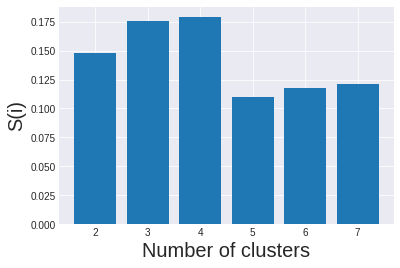

In [ ]:
k = [2, 3, 4, 5, 6, 7] 

# Appending the silhouette scores of the different models to the list 
silhouette_scores = [] 
silhouette_scores.append( 
		silhouette_score(baseline_HC_scaled, ac2.fit_predict(baseline_HC_scaled))) 
silhouette_scores.append( 
		silhouette_score(baseline_HC_scaled, ac3.fit_predict(baseline_HC_scaled))) 
silhouette_scores.append( 
		silhouette_score(baseline_HC_scaled, ac4.fit_predict(baseline_HC_scaled))) 
silhouette_scores.append( 
		silhouette_score(baseline_HC_scaled, ac5.fit_predict(baseline_HC_scaled))) 
silhouette_scores.append( 
		silhouette_score(baseline_HC_scaled, ac6.fit_predict(baseline_HC_scaled))) 
silhouette_scores.append( 
		silhouette_score(baseline_HC_scaled, ac7.fit_predict(baseline_HC_scaled))) 

# Plotting a bar graph to compare the results 
plt.bar(k, silhouette_scores) 
plt.xlabel('Number of clusters', fontsize = 20) 
plt.ylabel('S(i)', fontsize = 20) 
plt.show() 


In [ ]:
Hier_Cluster_Labels=AgglomerativeClustering(n_clusters=4).fit_predict(baseline_HC_scaled)
hc_score=silhouette_score(baseline_norm_v2,Hier_Cluster_Labels)
print(hc_score)

0.17879858071190197


In [ ]:
#Append Components and Label to the dataframe
baseline_HC_labels_v2 = pd.concat([baseline_HC_scaled.reset_index(drop= True), pd.DataFrame(HC_principal)], axis = 1)
baseline_HC_labels_v2['Hierarchical_Labels'] = Hier_Cluster_Labels

#Add Hierarchical Labels to baseline_pca_labels_v2
baseline_pca_labels_v2['Hierarchical_Labels'] = Hier_Cluster_Labels

<Figure size 432x288 with 0 Axes>

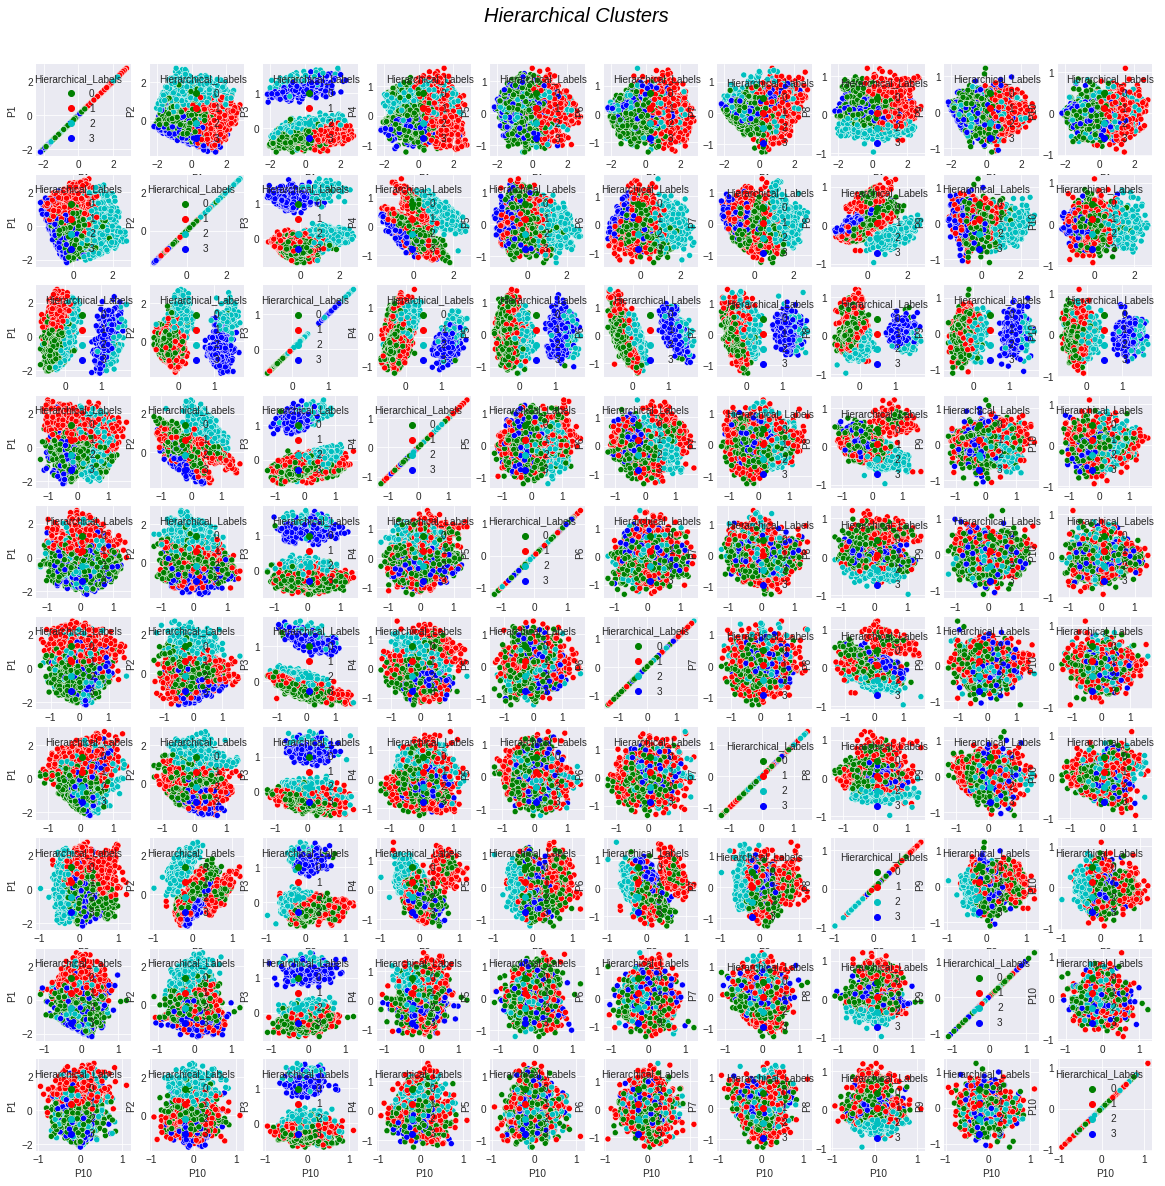

In [ ]:
import matplotlib.pyplot as plt

# Initialize the figure
plt.style.use('seaborn-darkgrid')
 
# create a color palette
palette = plt.get_cmap('Set1')
plt.tight_layout()
plt.subplots(5,5,figsize=(20,20))
plt.suptitle("Hierarchical Clusters", fontsize=20, fontweight=4, color='black', style='italic', x=0.5,y=0.92)

for rowx in range(1,11):
    for colx in range(1,11):
        plt.subplot(10,10,colx+(rowx-1)*10)
        xref=(70+rowx)
        yref=(70+colx)
        #x_val = baseline_pca_labels_v2.iloc[:, xref]
        #y_val = baseline_pca_labels_v2.iloc[:, yref]
        sns.scatterplot(baseline_pca_labels_v2.iloc[:, xref],baseline_pca_labels_v2.iloc[:, yref], hue=baseline_pca_labels_v2['Hierarchical_Labels'], palette = ['g','r','c','b'])

plt.show()
        #plt.xlabel(x_axis)
        #plt.ylabel(y_axis)

# Hierarchical Clustering (Data Subset)

In [ ]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.decomposition import PCA 
from sklearn.cluster import AgglomerativeClustering 
from sklearn.preprocessing import StandardScaler, normalize 
from sklearn.metrics import silhouette_score 
import scipy.cluster.hierarchy as shc 
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [ ]:
scaler = MinMaxScaler()
baseline_HC_norm_ss = scaler.fit_transform(baseline_subsetV3)
pd.DataFrame(baseline_HC_norm_ss).describe()

In [ ]:
#X_scaled_df = pd.DataFrame(X_scaled,columns=X.columns)
baseline_HC_norm_ss_df = pd.DataFrame(baseline_HC_norm_ss, columns=baseline_subsetV3.columns)  

In [ ]:

plt.figure(figsize =(8, 8)) 
plt.title('Dendrogram') 
cl_mergings = shc.linkage(baseline_HC_norm_ss, method="complete")
Dendrogram = dendrogram(cl_mergings)
#Dendrogram = shc.dendrogram((shc.linkage(X_principal, method ='ward')))



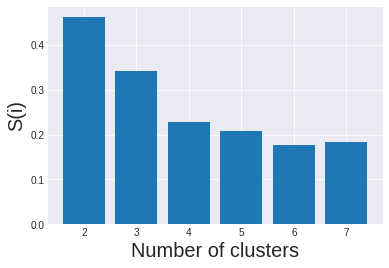

In [ ]:
k = [2, 3, 4, 5, 6, 7] 
ac2 = AgglomerativeClustering(n_clusters = 2) 
ac3 = AgglomerativeClustering(n_clusters = 3) 
ac4 = AgglomerativeClustering(n_clusters = 4) 
ac5 = AgglomerativeClustering(n_clusters = 5) 
ac6 = AgglomerativeClustering(n_clusters = 6) 
ac7 = AgglomerativeClustering(n_clusters = 7) 

# Appending the silhouette scores of the different models to the list 
silhouette_scores = [] 
silhouette_scores.append( 
		silhouette_score(baseline_HC_norm_ss, ac2.fit_predict(baseline_HC_norm_ss))) 
silhouette_scores.append( 
		silhouette_score(baseline_HC_norm_ss, ac3.fit_predict(baseline_HC_norm_ss))) 
silhouette_scores.append( 
		silhouette_score(baseline_HC_norm_ss, ac4.fit_predict(baseline_HC_norm_ss))) 
silhouette_scores.append( 
		silhouette_score(baseline_HC_norm_ss, ac5.fit_predict(baseline_HC_norm_ss))) 
silhouette_scores.append( 
		silhouette_score(baseline_HC_norm_ss, ac6.fit_predict(baseline_HC_norm_ss))) 
silhouette_scores.append( 
		silhouette_score(baseline_HC_norm_ss, ac7.fit_predict(baseline_HC_norm_ss))) 

# Plotting a bar graph to compare the results 
plt.bar(k, silhouette_scores) 
plt.xlabel('Number of clusters', fontsize = 20) 
plt.ylabel('S(i)', fontsize = 20) 
plt.show() 


In [ ]:
Hier_Cluster_Labels=cut_tree(cl_mergings,n_clusters=2).reshape(-1,)
hc_score=silhouette_score(baseline_HC_norm_ss_df,Hier_Cluster_Labels)
print(hc_score)

0.4615966622698429


In [ ]:
#Append Components and Label to the dataframe
#baseline_HC_labels_v2 = pd.concat([baseline_HC_scaled.reset_index(drop= True), pd.DataFrame(HC_principal)], axis = 1)
#baseline_HC_labels_v2['Hierarchical_Labels'] = Hier_Cluster_Labels

#Add Hierarchical Labels to baseline_pca_labels_v2
baseline_v2['Hierarchical_Labels'] = Hier_Cluster_Labels

In [ ]:
baseline_v2.groupby('Hierarchical_Labels').count()

Site_of_Onset___Bulbar  ...  GMMLabels
Hierarchical_Labels                          ...           
0                                      3151  ...       3151
1                                       591  ...        591

[2 rows x 76 columns]

In [ ]:
plt.figure(figsize = (10,8))

x_axis = baseline_pca_labels_v2.iloc[:, +71]
y_axis = baseline_pca_labels_v2.iloc[:, +73]

#x_axis = baseline_pca_labels.iloc[:, -1]
#y_axis = baseline_pca_labels.iloc[:, -9]

sns.scatterplot(x_axis,y_axis, hue=baseline_v2['Hierarchical_Labels'], palette = ['g','r','c'])
plt.title("Agglomerative Clusters", fontsize=20)

In [ ]:
import matplotlib.pyplot as plt

# Initialize the figure
plt.style.use('seaborn-darkgrid')
 
# create a color palette
palette = plt.get_cmap('Set1')
plt.tight_layout()
plt.subplots(5,5,figsize=(20,20))
plt.suptitle("Hierarchical Clusters", fontsize=20, fontweight=4, color='black', style='italic', x=0.5,y=0.92)

for rowx in range(1,6):
    for colx in range(1,6):
        plt.subplot(5,5,colx+(rowx-1)*5)
        xref=(rowx-12)
        yref=(colx-12)
        #x_val = baseline_pca_labels_v2.iloc[:, xref]
        #y_val = baseline_pca_labels_v2.iloc[:, yref]
        sns.scatterplot(baseline_pca_labels_v2.iloc[:, xref],baseline_pca_labels_v2.iloc[:, yref], hue=baseline_pca_labels_v2['Hierarchical_Labels'], palette = ['g','r','c','b'])

plt.show()
        #plt.xlabel(x_axis)
        #plt.ylabel(y_axis)

In [ ]:
plt.matshow(pca.components_,cmap='viridis')
plt.yticks([0,1,2,3,4,5,6,7,8],['Comp0','Comp1', 'Comp2','Comp3','Comp4','Comp5','Comp6','Comp7'],fontsize=10)
plt.colorbar()
plt.xticks(range(len(baseline_HC_labels_v2.columns)),baseline_HC_labels_v2.columns,rotation=65,ha='left')
#plt.tight_layout()
plt.show()# 

In [ ]:
plt.figure(figsize=(10,10))
plt.suptitle("Agglomerative Clusters: Q1,Q2,Q3 Median scores", fontsize=20, fontweight=4, color='black', x=0.5,y=0.92)
plt.xlabel("Agglomerative Clusters", fontsize=20, fontweight=4, color='black', x=0.5,y=0.01)

plt.subplot(1,3,1)
sns.boxplot(x='Hierarchical_Labels', y='Q1_Speech_median', data=baseline_v2).set(xlabel='', ylabel='Q1 Speech Median')

plt.subplot(1,3,2)
sns.boxplot(x='Hierarchical_Labels', y='Q2_Salivation_median', data=baseline_v2).set(xlabel='', ylabel='Q2 Salivation Median')

plt.subplot(1,3,3)
sns.boxplot(x='Hierarchical_Labels', y='Q3_Swallowing_median', data=baseline_v2).set(xlabel='', ylabel='Q3 Swallowing Median')

In [ ]:
plt.figure(figsize=(10,10))
plt.suptitle("Agglomerative Clusters: Q1,Q2,Q3 Slope", fontsize=20, fontweight=4, color='black', x=0.5,y=0.92)
plt.xlabel("Agglomerative Clusters", fontsize=20, fontweight=4, color='black', x=0.5,y=0.01)

plt.subplot(1,3,1)
sns.boxplot(x='Hierarchical_Labels', y='Q1_Speech_slope', data=baseline_v2,showfliers=False).set(xlabel='', ylabel='Q1 Speech Slope')

plt.subplot(1,3,2)
sns.boxplot(x='Hierarchical_Labels', y='Q2_Salivation_slope', data=baseline_v2,showfliers=False).set(xlabel='', ylabel='Q2 Salivation Slope')

plt.subplot(1,3,3)
sns.boxplot(x='Hierarchical_Labels', y='Q3_Swallowing_slope', data=baseline_v2,showfliers=False).set(xlabel='', ylabel='Q3 Swallowing Slope')

In [ ]:
plt.figure(figsize=(15,12))
plt.suptitle("Agglomerative Clusters: ALSFRS Scores", fontsize=20, fontweight=4, color='black', x=0.5,y=0.92)
plt.xlabel("Gower method: K-medoids clusters", fontsize=20, fontweight=4, color='black', x=0.5,y=0.01)
plt.tight_layout

plt.subplot(1,3,1)
sns.boxplot(x='Hierarchical_Labels', y='ALSFRS_Slope', data=baseline_v2, showfliers=False).set(xlabel='', ylabel='ALSFRS Slope')

plt.subplot(1,3,2)
sns.boxplot(x='Hierarchical_Labels', y='ALSFRS_total_median', data=baseline_v2, showfliers=False).set(xlabel='', ylabel='ALSFRS Median')

plt.subplot(1,3,3)
sns.boxplot(x='Hierarchical_Labels', y='ALSFRS_total_min', data=baseline_v2, showfliers=False).set(xlabel='', ylabel='ALSFRS Min')